In [154]:
import pygsti
import numpy as np
from scipy.linalg import expm
from pygsti.circuits import Circuit
from matplotlib import pyplot as plt
from pygsti.processors import QuditProcessorSpec

# target model def

In [730]:
# Gell-Mann matrices
gellmann_matrices = [
    np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]),
    np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]]),
    np.array([[0, -1j, 0], [1j, 0, 0], [0, 0, 0]]),
    np.array([[1, 0, 0], [0, -1, 0], [0, 0, 0]]),
    np.array([[0, 0, 1], [0, 0, 0], [1, 0, 0]]),
    np.array([[0, 0, -1j], [0, 0, 0], [1j, 0, 0]]),
    np.array([[0, 0, 0], [0, 0, 1], [0, 1, 0]]),
    np.array([[0, 0, 0], [0, 0, -1j], [0, 1j, 0]]),
    np.array([[1, 0, 0], [0, 1, 0], [0, 0, -2]])
]

gellmann_8_12 = np.array([[-2, 0, 0], [0, 1, 0], [0, 0, 1]])

In [731]:
# unitary models 
# we ignore axis error 
def modelX01(theta, gamma):
    return expm(-(1j/2)*((np.pi/2 + theta)*gellmann_matrices[1] + gamma*gellmann_matrices[8]))

def modelZ01():
    return np.diag([np.exp(-1j*np.pi/4), 1, 1])

def modelZ12():
    return  np.diag([1, 1, np.exp(-1j*np.pi/4)])

X12_gen = np.array([[0, 0, 0], [0, 0, 1], [0, 1, 0]])

def modelX12(theta):
    return expm(-(1j/2)*((np.pi/2 + theta)*X12_gen))

def modelCZ(phis):
    return np.diag([1]+[np.exp(-1j*phi) for phi in phis])



In [732]:
X01

array([[0.70710678+0.j        , 0.        -0.70710678j,
        0.        +0.j        ],
       [0.        -0.70710678j, 0.70710678+0.j        ,
        0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        1.        +0.j        ]])

In [733]:
Z01

array([[0.70710678-0.70710678j, 0.        +0.j        ,
        0.        +0.j        ],
       [0.        +0.j        , 1.        +0.j        ,
        0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        1.        +0.j        ]])

In [734]:
def plot_real_and_imag_parts(mat, title):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(np.real(mat), cmap='viridis', interpolation='nearest')
    axs[0].set_title('Real part')
    axs[1].imshow(np.imag(mat), cmap='viridis', interpolation='nearest')
    axs[1].set_title('Imaginary part')
    fig.suptitle(title)
    # add colorbars
    plt.colorbar(axs[0].imshow(np.real(mat), cmap='viridis', interpolation='nearest'), ax=axs[0])
    plt.colorbar(axs[1].imshow(np.imag(mat), cmap='viridis', interpolation='nearest'), ax=axs[1])
    plt.show()

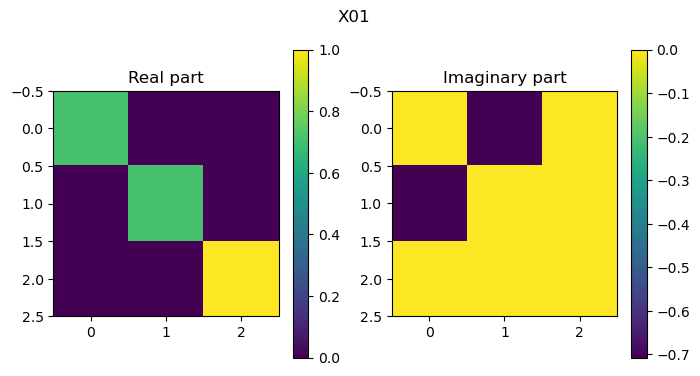

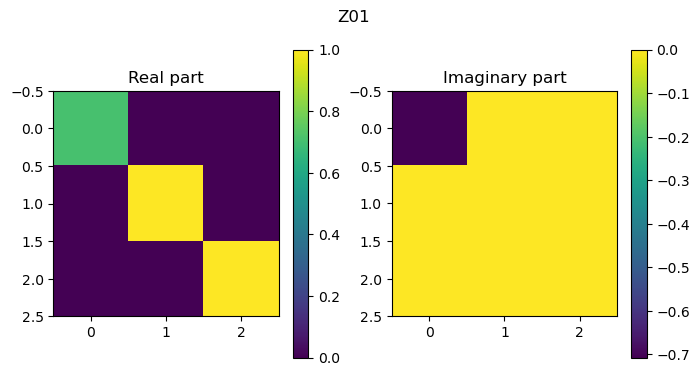

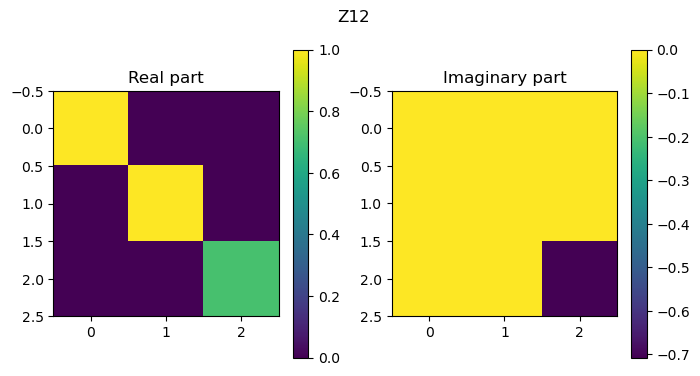

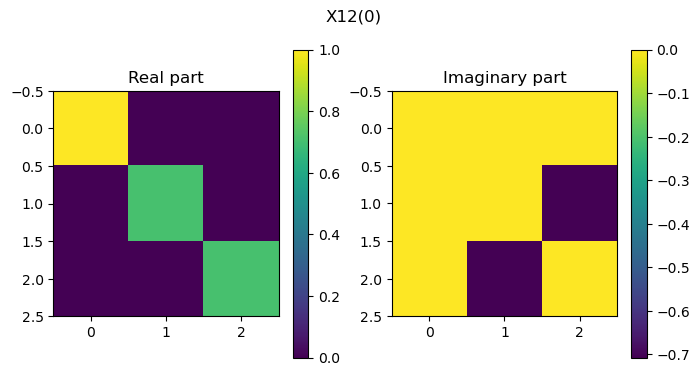

In [735]:
plot_real_and_imag_parts(modelX01(0, 0), 'X01')
plot_real_and_imag_parts(modelZ01(), 'Z01')
plot_real_and_imag_parts(modelZ12(), 'Z12')
plot_real_and_imag_parts(modelX12(0), 'X12(0)')

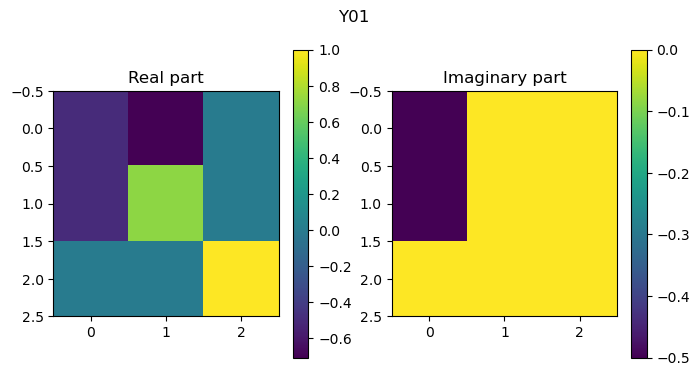

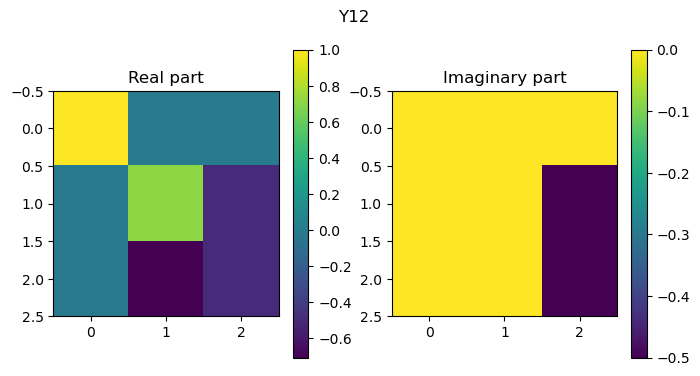

In [736]:
Z01 = modelZ01()
X01 = modelX01(0, 0)
Z12 = modelZ12()
X12 = modelX12(0)

Y01 = Z01@Z01@X01@Z01
Y12 = Z12@Z12@X12@Z12

plot_real_and_imag_parts(Y01, 'Y01')
plot_real_and_imag_parts(Y12, 'Y12')

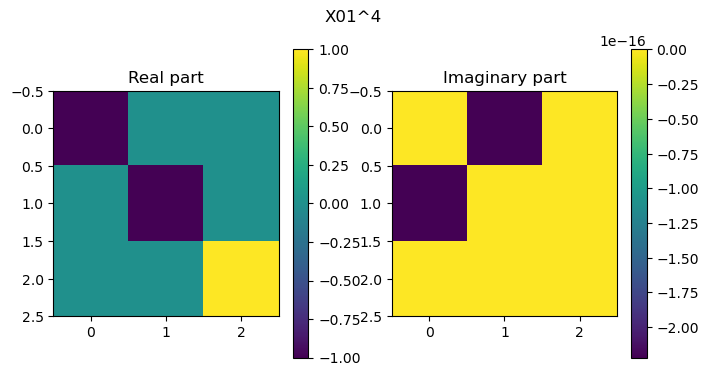

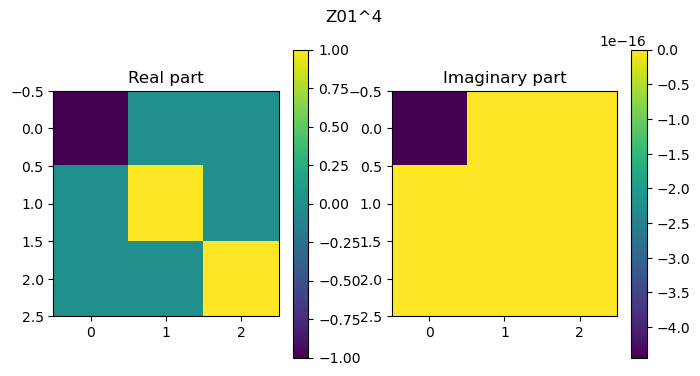

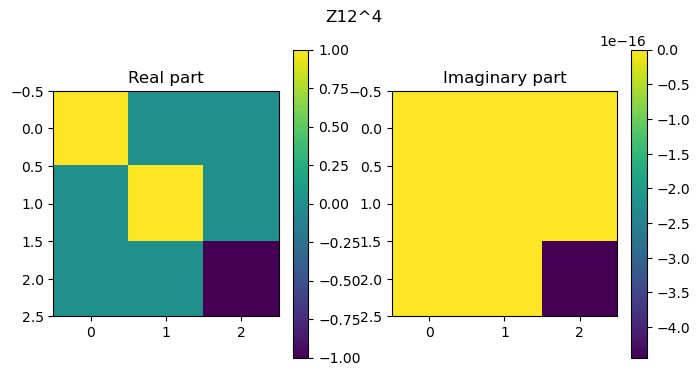

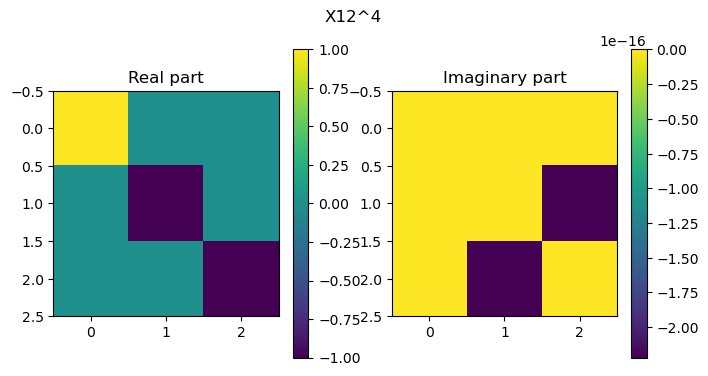

In [737]:
# observe that the inverse of these gates require a Zpi rotation on the pair that is not the target
Gx01_4 = np.linalg.matrix_power(X01, 4)
Gz01_4 = np.linalg.matrix_power(Z01, 4)
Gz12_4 = np.linalg.matrix_power(Z12, 4)
Gx12_4 = np.linalg.matrix_power(X12, 4)

plot_real_and_imag_parts(Gx01_4, 'X01^4')
plot_real_and_imag_parts(Gz01_4, 'Z01^4')
plot_real_and_imag_parts(Gz12_4, 'Z12^4')
plot_real_and_imag_parts(Gx12_4, 'X12^4')

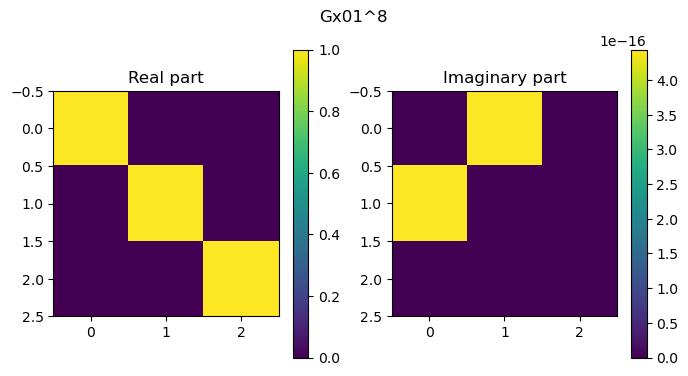

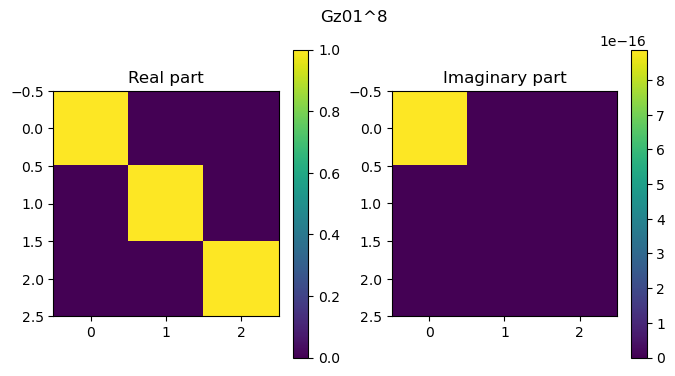

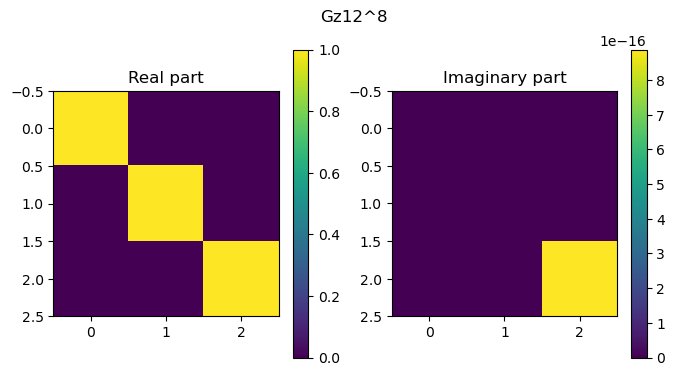

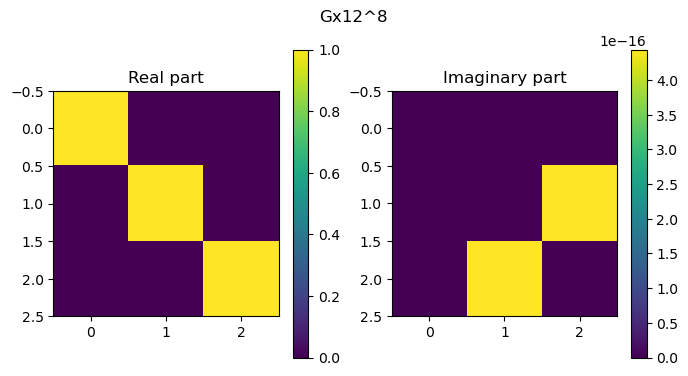

In [738]:
# observe that the inverse of these gates actually require 8 rotations
Gx01_4_Z12pi = np.linalg.matrix_power(X01, 8)
Gz01_4_Z12pi = np.linalg.matrix_power(Z01, 8)
Gz12_4_Z01pi = np.linalg.matrix_power(Z12, 8) 
Gx12_4_Z01pi = np.linalg.matrix_power(X12, 8)

plot_real_and_imag_parts(Gx01_4_Z12pi, 'Gx01^8')
plot_real_and_imag_parts(Gz01_4_Z12pi, 'Gz01^8')
plot_real_and_imag_parts(Gz12_4_Z01pi, 'Gz12^8')
plot_real_and_imag_parts(Gx12_4_Z01pi, 'Gx12^8')

In [739]:
rho0vec = np.asarray([1, 0, 0])
Y01@Y12@X01@X01@rho0vec

array([-1.66533454e-16+0.5j       , -8.32667268e-17-0.5j       ,
       -1.57009246e-16+0.70710678j])

In [740]:
rho0vec = np.asarray([1, 0, 0])
Y01@X12@X12@X12@X01@X01@rho0vec

array([ 0.00000000e+00-0.5j, -8.32667268e-17+0.5j, -7.07106781e-01+0.j ])

In [741]:
rho0vec = np.asarray([1, 0, 0])
rho00= np.kron(rho0vec, rho0vec)

E0vec = np.asarray([1, 0, 0])
E1vec = np.asarray([0, 1, 0])
E2vec = np.asarray([0, 0, 1])

E00 = np.kron(E0vec, E0vec)
E01 = np.kron(E0vec, E1vec)
E02 = np.kron(E0vec, E2vec)
E10 = np.kron(E1vec, E0vec)
E11 = np.kron(E1vec, E1vec)
E12 = np.kron(E1vec, E2vec)
E20 = np.kron(E2vec, E0vec)
E21 = np.kron(E2vec, E1vec)
E22 = np.kron(E2vec, E2vec)

povm_dict = {'00' : E00, '01' : E01, '02' : E02, '10' : E10, '11' : E11, '12' : E12, '20' : E20, '21' : E21, '22' : E22}

phis_target = np.array([0, 0, 0, -2*np.pi/3, -4*np.pi/3, 0, -2*np.pi/3, -4*np.pi/3])
gate_names = ['Gx_01_Q1', 'Gx_12_Q1', 'Gz_01_Q1', 'Gz_12_Q1', 'Gx_01_Q2', 'Gx_12_Q2', 'Gz_01_Q2', 'Gz_12_Q2', 'Gcz']
target_unitary_mapping = {
    'Gx_01_Q1': modelX01(0,0), 
    'Gx_12_Q1': modelX12(0), 
    'Gz_01_Q1': modelZ01(), 
    'Gz_12_Q1': modelZ12(),
    'Gx_01_Q2': modelX01(0,0),
    'Gx_12_Q2': modelX12(0),
    'Gz_01_Q2': modelZ01(),
    'Gz_12_Q2': modelZ12(),
    'Gcz': modelCZ(phis_target)
}
availability = {
    'Gx_01_Q1': [('Q1', )], 
    'Gx_12_Q1': [('Q1', )], 
    'Gz_01_Q1': [('Q1', )], 
    'Gz_12_Q1': [('Q1', )], 
    'Gx_01_Q2': [('Q2', )], 
    'Gx_12_Q2': [('Q2', )], 
    'Gz_01_Q2': [('Q2', )], 
    'Gz_12_Q2': [('Q2', )], 
    'Gcz': [('Q1', 'Q2')]
}



pspec = QuditProcessorSpec(['Q1', 'Q2'], qudit_udims=[3, 3], gate_names=gate_names,
                    nonstd_gate_unitaries=target_unitary_mapping,
                    prep_names = ['rho0'], povm_names = ['Mdefault'], 
                    nonstd_preps = {'rho0': rho00}, nonstd_povms = {'Mdefault': povm_dict}, 
                    availability=availability
                    )

In [742]:
target_model = pygsti.models.modelconstruction.create_explicit_model(pspec, 
                                                              ideal_gate_type='full TP', 
                                                              ideal_spam_type='full pure', 
                                                              basis='gm')

# Circuit construction

In [743]:
prep_dict = {
    '00' : ([]), 
}

meas_dict = {
    '00' : ([]),
}

gate_dict = {
    'G_CZ' : ([('Gcz', 'Q1', 'Q2')]),
    'G_X01' : ([('G_X01(Q1)', 'Q1')]),
    'G_Z01' : ([('G_Z01(Q1)', 'Q1')]),
    'G_X12' : ([('G_X12(Q1)', 'Q1')]),
    'G_Z12' : ([('G_Z12(Q1)', 'Q1')]),
    'G_X01' : ([('G_X01(Q2)', 'Q2')]),
    'G_Z01' : ([('G_Z01(Q2)', 'Q2')]),
    'G_X12' : ([('G_X12(Q2)', 'Q2')]),
    'G_Z12' : ([('G_Z12(Q2)', 'Q2')]),
}

def make_circuit(gate, prep_label, meas_label, depth):
    prep_circ = prep_dict[prep_label]
    meas_circ = meas_dict[meas_label]
    return Circuit(['rho0'] + prep_circ + [gate]*depth + meas_circ + ['Mdefault'], line_labels=['Q1', 'Q2'])

In [744]:
# simulate a circuit under the target model 

circ = make_circuit(('Gx_01_Q2', 'Q2'), '00', '00', 2)
print(circ)

target_model.probabilities(circ)

Qubit Q1 ---|rho0|-|        |-|        |-|Mdefault|---
Qubit Q2 ---|rho0|-|Gx_01_Q2|-|Gx_01_Q2|-|Mdefault|---



OutcomeLabelDict([(('00',), -1.6479873021779667e-16),
                  (('01',), 0.9999999999999997),
                  (('02',), -1.4051260155412137e-16),
                  (('10',), -1.0581813203458523e-16),
                  (('11',), -3.9898639947466563e-17),
                  (('12',), -2.480654570646834e-16),
                  (('20',), -1.0928757898653885e-16),
                  (('21',), -1.43982048506075e-16),
                  (('22',), -1.6653345369377348e-16)])

# Error model definitions

In [745]:
def parse_error_vector(x):
    info = {
        'single_qutrit': {
            'Q1': {
                'X01' : x[0],
                'phase': x[1],
                'X12' : x[2], 
            },
            'Q2': {
                'X01' : x[3],
                'phase': x[4],
                'X12' : x[5],
            }
        },
        'two_qutrit': {
            'phi1': x[6],
            'phi2': x[7],
            'phi3': x[8],
            'phi4': x[9],
            'phi5': x[10],
            'phi6': x[11],
            'phi7': x[12],
            'phi8': x[13]
        }  
    }
    return info

def random_error_vector(single_qutrit_rates, two_qutrit_rates):
    q1_vec = np.random.multivariate_normal(np.zeros(3), np.eye(3)*single_qutrit_rates)
    q2_vec = np.random.multivariate_normal(np.zeros(3), np.eye(3)*single_qutrit_rates)
    two_qubit_vec = np.random.multivariate_normal(np.zeros(8), np.eye(8)*two_qutrit_rates)
    return np.concatenate((q1_vec, q2_vec, two_qubit_vec))


In [746]:
from pygsti.tools import unitary_to_std_process_mx
from pygsti.modelmembers.operations import EmbeddedOp, FullArbitraryOp

In [747]:
from pygsti.baseobjs import ExplicitStateSpace
from pygsti.models import ExplicitOpModel
from pygsti.models.modelconstruction import create_spam_vector
from pygsti.modelmembers.povms import UnconstrainedPOVM, FullPOVMEffect
from pygsti.modelmembers.states import FullState
from pygsti.tools import change_basis
from pygsti.baseobjs import Basis


def make_model(error_vector, single_qutrit_depol, two_qutrit_depol):
    
    # Parse error vector
    errors = parse_error_vector(error_vector)
    x01_Q1 = errors['single_qutrit']['Q1']['X01']
    x12_Q1 = errors['single_qutrit']['Q1']['X12']
    x01_Q2 = errors['single_qutrit']['Q2']['X01']
    x12_Q2 = errors['single_qutrit']['Q2']['X12']
    
    phase_Q1 = errors['single_qutrit']['Q1']['phase']
    phase_Q2 = errors['single_qutrit']['Q2']['phase']

    phi1 = errors['two_qutrit']['phi1']
    phi2 = errors['two_qutrit']['phi2']
    phi3 = errors['two_qutrit']['phi3']
    phi4 = errors['two_qutrit']['phi4']
    phi5 = errors['two_qutrit']['phi5']
    phi6 = errors['two_qutrit']['phi6']
    phi7 = errors['two_qutrit']['phi7']
    phi8 = errors['two_qutrit']['phi8']
    phis = [phi1, phi2, phi3, phi4, phi5, phi6, phi7, phi8]

    # Define single qutrit unitaries
    X01_Q1_unitary = modelX01(x01_Q1, phase_Q1)
    Z01_Q1_unitary = modelZ01()
    X12_Q1_unitary = modelX12(x12_Q1)
    Z12_Q1_unitary = modelZ12()

    X01_Q2_unitary = modelX01(x01_Q2, phase_Q2)
    Z01_Q2_unitary = modelZ01()
    X12_Q2_unitary = modelX12(x12_Q2)
    Z12_Q2_unitary = modelZ12()

    # Define two qutrit unitary
    phis_target = np.array([0, 0, 0, -2*np.pi/3, -4*np.pi/3, 0, -2*np.pi/3, -4*np.pi/3])
    CZ_unitary = modelCZ(np.array(phis) + phis_target)

    target_unitary_mapping = {
        'Gx_01_Q1': X01_Q1_unitary,
        'Gx_12_Q1': X12_Q1_unitary,
        'Gz_01_Q1': Z01_Q1_unitary,
        'Gz_12_Q1': Z12_Q1_unitary,
        'Gx_01_Q2': X01_Q2_unitary,
        'Gx_12_Q2': X12_Q2_unitary,
        'Gz_01_Q2': Z01_Q2_unitary,
        'Gz_12_Q2': Z12_Q2_unitary,
        'Gcz': CZ_unitary
    }

    rho0vec = np.asarray([1, 0, 0])
    rho00= np.kron(rho0vec, rho0vec)

    E0vec = np.asarray([1, 0, 0])
    E1vec = np.asarray([0, 1, 0])
    E2vec = np.asarray([0, 0, 1])

    E00 = np.kron(E0vec, E0vec)
    E01 = np.kron(E0vec, E1vec)
    E02 = np.kron(E0vec, E2vec)
    E10 = np.kron(E1vec, E0vec)
    E11 = np.kron(E1vec, E1vec)
    E12 = np.kron(E1vec, E2vec)
    E20 = np.kron(E2vec, E0vec)
    E21 = np.kron(E2vec, E1vec)
    E22 = np.kron(E2vec, E2vec)

    povm_dict = {'00' : E00, '01' : E01, '02' : E02, '10' : E10, '11' : E11, '12' : E12, '20' : E20, '21' : E21, '22' : E22}

    
    gate_names = ['Gx_01_Q1', 'Gx_12_Q1', 'Gz_01_Q1', 'Gz_12_Q1', 'Gx_01_Q2', 'Gx_12_Q2', 'Gz_01_Q2', 'Gz_12_Q2', 'Gcz']
    availability = {
        'Gx_01_Q1': [('Q1', )], 
        'Gx_12_Q1': [('Q1', )], 
        'Gz_01_Q1': [('Q1', )], 
        'Gz_12_Q1': [('Q1', )], 
        'Gx_01_Q2': [('Q2', )], 
        'Gx_12_Q2': [('Q2', )], 
        'Gz_01_Q2': [('Q2', )], 
        'Gz_12_Q2': [('Q2', )], 
        'Gcz': [('Q1', 'Q2')]
    }

    # define the processor spec
    pspec = QuditProcessorSpec(['Q1', 'Q2'], qudit_udims=[3, 3], gate_names=gate_names,
                    nonstd_gate_unitaries=target_unitary_mapping,
                    prep_names = ['rho0'], povm_names = ['Mdefault'],
                    nonstd_preps = {'rho0': rho00}, nonstd_povms = {'Mdefault': povm_dict},
                    availability=availability
                    )
    model = pygsti.models.modelconstruction.create_explicit_model(pspec,ideal_gate_type='full TP', ideal_spam_type='full pure', basis='gm')

    # add depolarizing noise
    model.operations[('Gx_01_Q1', 'Q1')].depolarize(single_qutrit_depol)
    model.operations[('Gz_01_Q1', 'Q1')].depolarize(single_qutrit_depol)
    model.operations[('Gx_12_Q1', 'Q1')].depolarize(single_qutrit_depol)
    model.operations[('Gz_12_Q1', 'Q1')].depolarize(single_qutrit_depol)
    model.operations[('Gx_01_Q2', 'Q2')].depolarize(single_qutrit_depol)
    model.operations[('Gz_01_Q2', 'Q2')].depolarize(single_qutrit_depol)
    model.operations[('Gx_12_Q2', 'Q2')].depolarize(single_qutrit_depol)
    model.operations[('Gz_12_Q2', 'Q2')].depolarize(single_qutrit_depol)
    model.operations[('Gcz', 'Q1', 'Q2')].depolarize(two_qutrit_depol)

    return model


    # # Define single qutrit gates
    # X01_Q1_unitary = unitary_to_std_process_mx(modelX01(x01_Q1, phase01_Q1))
    # Z01_Q1_unitary = unitary_to_std_process_mx(modelZ01())
    # X12_Q1_unitary = unitary_to_std_process_mx(modelX12(x12_Q1, phase12_Q1))
    # Z12_Q1_unitary = unitary_to_std_process_mx(modelZ12())

    # X01_Q1_gate = FullArbitraryOp(X01_Q1_unitary, evotype='densitymx', basis='gm')
    # Z01_Q1_gate = FullArbitraryOp(Z01_Q1_unitary, evotype='densitymx', basis='gm')
    # X12_Q1_gate = FullArbitraryOp(X12_Q1_unitary, evotype='densitymx', basis='gm')
    # Z12_Q1_gate = FullArbitraryOp(Z12_Q1_unitary, evotype='densitymx', basis='gm')

    # X01_Q1_gate.depolarize(single_qutrit_depol)
    # Z01_Q1_gate.depolarize(single_qutrit_depol)
    # X12_Q1_gate.depolarize(single_qutrit_depol)
    # Z12_Q1_gate.depolarize(single_qutrit_depol)

    # X01_Q2_unitary = unitary_to_std_process_mx(modelX01(x01_Q2, phase01_Q2))
    # Z01_Q2_unitary = unitary_to_st_inv + circ_X12_Q1_inv + [('Gx_01_Q1', 'Q1')]*6d_process_mx(modelZ01())
    # X12_Q2_unitary = unitary_to_std_process_mx(modelX12(x12_Q2, phase12_Q2))
    # Z12_Q2_unitary = unitary_to_std_process_mx(modelZ12())


    # X01_Q2_gate = FullArbitraryOp(X01_Q1_unitary, evotype='densitymx', basis='gm')
    # Z01_Q2_gate = FullArbitraryOp(Z01_Q1_unitary, evotype='densitymx', basis='gm')
    # X12_Q2_gate = FullArbitraryOp(X12_Q1_unitary, evotype='densitymx', basis='gm')
    # Z12_Q2_gate = FullArbitraryOp(Z12_Q1_unitary, evotype='densitymx', basis='gm')
                               
    # X01_Q2_gate.depolarize(single_qutrit_depol)
    # Z01_Q2_gate.depolarize(single_qutrit_depol)
    # X12_Q2_gate.depolarize(single_qutrit_depol)
    # Z12_Q2_gate.depolarize(single_qutrit_depol)

    # # Define two qutrit gates
    # CZ_unitary = unitary_to_std_process_mx(modelCZ(phis))
    # CZ_mat = change_basis(CZ_unitary, 'std', 'gm')
    # CZ = FullArbitraryOp(CZ_mat, evotype='densitymx', basis='gm')
    # CZ.depolarize(two_qutrit_depol)

    # # Add gates to model
    # joint_state_space = model.state_space
    # model.operations[('Gx_01', 'Q1')] = X01_Q1_gate
    # model.operations[('Gz_01', 'Q1')] = Z01_Q1_gate
    # model.operations[('Gx_12', 'Q1')] = X12_Q1_gate
    # model.operations[('Gz_12', 'Q1')] = Z12_Q1_gate
    # model.operations[('Gx_01', 'Q2')] = X01_Q2_gate
    # model.operations[('Gz_01', 'Q2')] = Z01_Q2_gate
    # model.operations[('Gx_12', 'Q2')] = X12_Q2_gate
    # model.operations[('Gz_12', 'Q2')] = Z12_Q2_gate

    # model.operations['Gcz'] = CZ

    # return model

In [748]:
def plot_outcome_dist_2qt(outcomes, target=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    # keys a
    keys = ['00', '01', '02', '10', '11', '12', '20', '21', '22']
    vals = np.zeros(9)
    if target is not None:
        tag_vals = np.zeros(9)
        for idx, key in enumerate(keys):
            if key in target:
                tag_vals[idx] = target[key]
    for idx, key in enumerate(keys):
        if key in outcomes:
            vals[idx] = outcomes[key]
    if target is None:
        ax.bar(keys, vals)
    else:
        ax.bar(keys, vals, label='Simulated', alpha=0.5)
        ax.bar(keys, tag_vals, label='Target', alpha=0.5)
        ax.legend()

Qubit Q1 ---|rho0|-|Gx_01_Q1|-|Gx_01_Q1|-|Gx_01_Q1|-|Gx_01_Q1|-|Gx_01_Q1|-|Gx_01_Q1|-|Gx_01_Q1|-|Gx_01_Q1|-|Gx_01_Q1|-|Gx_01_Q1|-|Gx_01_Q1|-|Mdefault|---
Qubit Q2 ---|rho0|-|        |-|        |-|        |-|        |-|        |-|        |-|        |-|        |-|        |-|        |-|        |-|Mdefault|---

OutcomeLabelDict([(('00',), 0.07649138450604048), (('01',), 0.07624326710111054), (('02',), 0.07624326710111076), (('10',), 0.3898057457861804), (('11',), 0.07624326710111065), (('12',), 0.07624326710111057), (('20',), 0.0762432671011108), (('21',), 0.0762432671011106), (('22',), 0.0762432671011107)])


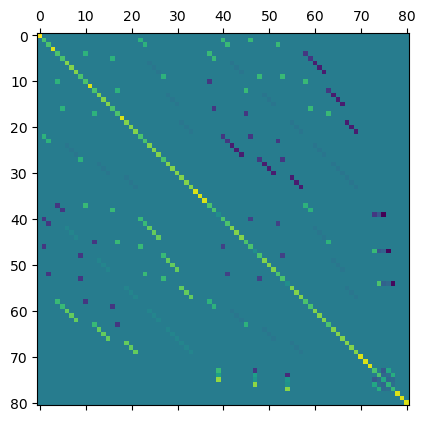

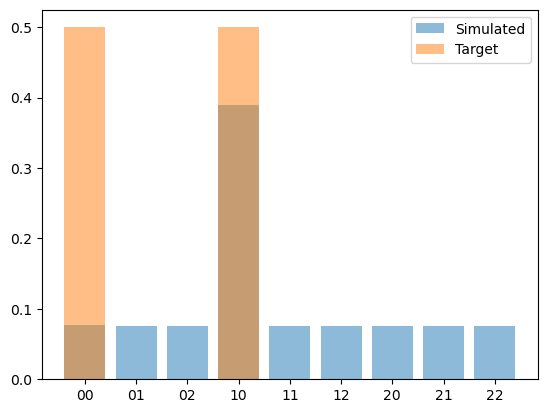

In [749]:
x = random_error_vector(0.1, 0.1)
model = make_model(x, 0.1, 0.1)
plt.matshow(model[(('Gx_01_Q1', 'Q1'))].to_dense().real)
circ = make_circuit(('Gx_01_Q1', 'Q1'), '00', '00', 11)
print(circ)
probs = model.probabilities(circ)
target_probs = target_model.probabilities(circ)
print(probs)
plot_outcome_dist_2qt(probs, target_probs)

# Single qutrit RPE

In [750]:
circ_Y01_Q1 = [('Gz_01_Q1', 'Q1')] + [('Gx_01_Q1', 'Q1')] + [('Gz_01_Q1', 'Q1')]*3
circ_Y12_Q1 = [('Gz_12_Q1', 'Q1')] + [('Gx_12_Q1', 'Q1')] + [('Gz_12_Q1', 'Q1')]*3

circ_X01_Q1_inv = [('Gx_01_Q1', 'Q1')]*7
circ_X12_Q1_inv = [('Gx_12_Q1', 'Q1')]*7
circ_Y01_Q1_inv = circ_Y01_Q1*7
circ_Y12_Q1_inv = circ_Y12_Q1*7

fiducial_prep_dict = {
    'id' : [],
    'X01_Q1_cos_prep': [], 
    'X01_Q1_sin_prep': [], 
    'X12_Q1_cos_prep': [('Gx_01_Q1', 'Q1'), ('Gx_01_Q1', 'Q1')],
    'X12_Q1_sin_prep': [('Gx_01_Q1', 'Q1'), ('Gx_01_Q1', 'Q1')],
    'phase_Q1_cos_prep': [('Gx_01_Q1', 'Q1'), ('Gx_01_Q1', 'Q1')] + [('Gx_12_Q1', 'Q1')] + circ_Y01_Q1,
    'phase_Q1_sin_prep': [('Gx_01_Q1', 'Q1'), ('Gx_01_Q1', 'Q1')] + [('Gx_12_Q1', 'Q1')] + circ_Y01_Q1,
}

fiducial_meas_dict = {
    'id' : [],
    'X01_Q1_cos_meas': [], 
    'X01_Q1_sin_meas': [('Gx_01_Q1', 'Q1'),],
    'X12_Q1_cos_meas': [],
    'X12_Q1_sin_meas': [('Gx_12_Q1', 'Q1'),],
    'phase_Q1_cos_meas': circ_Y01_Q1_inv + circ_X12_Q1_inv + [('Gx_01_Q1', 'Q1')]*6,
    'phase_Q1_sin_meas': circ_Y01_Q1_inv + circ_Y12_Q1_inv + [('Gx_01_Q1', 'Q1')]*6, 
}

In [751]:
def make_rpe_circuit(gate, prep_label, meas_label, depth):
    prep_circ = fiducial_prep_dict[prep_label]
    meas_circ = fiducial_meas_dict[meas_label]
    return Circuit(['rho0'] + prep_circ + gate*depth + meas_circ + ['Mdefault'], line_labels=['Q1', 'Q2'])

In [752]:
circ = fiducial_prep_dict['phase_Q1_cos_prep'] + ['Mdefault']
print(circ)
target_model.probabilities(circ)


[('Gx_01_Q1', 'Q1'), ('Gx_01_Q1', 'Q1'), ('Gx_12_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gx_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), 'Mdefault']


OutcomeLabelDict([(('00',), 0.2499999999999995),
                  (('01',), -2.0296264668928643e-16),
                  (('02',), -1.5439038936193583e-16),
                  (('10',), 0.24999999999999967),
                  (('11',), -9.540979117872439e-17),
                  (('12',), -2.1337098754514727e-16),
                  (('20',), 0.49999999999999933),
                  (('21',), -3.4867941867133823e-16),
                  (('22',), -2.0816681711721685e-16)])

In [753]:
circ = fiducial_prep_dict['phase_Q1_cos_prep'] + fiducial_meas_dict['phase_Q1_cos_meas'] +['Mdefault']
print(circ)
print(target_model.probabilities(circ))
print(model.probabilities(circ))


[('Gx_01_Q1', 'Q1'), ('Gx_01_Q1', 'Q1'), ('Gx_12_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gx_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gx_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gx_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gx_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gx_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gx_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gx_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gx_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gz_01_Q1', 'Q1'), ('Gx_12_Q1', 'Q1'), ('Gx_12_Q1', 'Q1'), ('Gx_12_Q1', 'Q1'), ('Gx_12_Q1', 'Q1'), ('Gx_12_Q1', 'Q1'), ('Gx_12_Q1', 'Q1'), ('Gx_12_Q1', 'Q1'),

In [799]:
def make_single_qutrit_rpe_edesign_Q1(depths):
    circuits = {
        'X01' : {'cos': [], 'sin': []},
        'X01' : {'cos': [], 'sin': []},
        'X12' : {'cos': [], 'sin': []},
        'X12' : {'cos': [], 'sin': []},
        'phase' : {'cos': [], 'sin': []},
        'phase' : {'cos': [], 'sin': []},
    }
    for depth in depths:
        circuits['X01']['cos'].append(make_rpe_circuit([('Gx_01_Q1', 'Q1')], 'X01_Q1_cos_prep', 'X01_Q1_cos_meas', depth))
        circuits['X01']['sin'].append(make_rpe_circuit([('Gx_01_Q1', 'Q1')], 'X01_Q1_sin_prep', 'X01_Q1_sin_meas', depth))
        circuits['X12']['cos'].append(make_rpe_circuit([('Gx_12_Q1', 'Q1')], 'X12_Q1_cos_prep', 'X12_Q1_cos_meas', depth))
        circuits['X12']['sin'].append(make_rpe_circuit([('Gx_12_Q1', 'Q1')], 'X12_Q1_sin_prep', 'X12_Q1_sin_meas', depth))
        circuits['phase']['cos'].append(make_rpe_circuit([('Gx_01_Q1', 'Q1')]*8, 'phase_Q1_cos_prep', 'phase_Q1_cos_meas', depth))
        circuits['phase']['sin'].append(make_rpe_circuit([('Gx_01_Q1', 'Q1')]*8, 'phase_Q1_sin_prep', 'phase_Q1_sin_meas', depth))
    return circuits
        
def edesign_to_circuit_list(edesign):
    circuits = []
    for etype in edesign.keys():
        for mtype in edesign[etype].keys():
            for circuit in edesign[etype][mtype]:
                circuits.append(circuit)
    return pygsti.tools.remove_duplicates(circuits)


In [800]:
import pygsti

In [801]:
from quapack.pyRPE import RobustPhaseEstimation
from quapack.pyRPE.quantum import Q as _rpeQ

def estimate_phase_from_dataset(ds, cos_circs, cos_outcome0s, cos_outcome1s, sin_circs, sin_outcome0s, sin_outcome1s, depths):
    experiment = _rpeQ()
    for idx, d in enumerate(depths):
        if d == 0:
            continue
        cos_0_counts = sum([ds[cos_circs[idx]].counts[ci] for ci in cos_outcome0s])
        cos_1_counts = sum([ds[cos_circs[idx]].counts[ci] for ci in cos_outcome1s])
        sin_0_counts = sum([ds[sin_circs[idx]].counts[ci] for ci in sin_outcome0s])
        sin_1_counts = sum([ds[sin_circs[idx]].counts[ci] for ci in sin_outcome1s])
        experiment.process_cos(d, (int(cos_0_counts), int(cos_1_counts)))
        experiment.process_sin(d, (int(sin_0_counts), int(sin_1_counts)))
    analysis = RobustPhaseEstimation(experiment)
    last_good_generation = analysis.check_unif_local(historical=True)
    estimates = analysis.angle_estimates
    return estimates, last_good_generation

In [833]:
x = random_error_vector(0.001, 0.001)
model = make_model(x, 0.00, 0.00)
depths = [2**i for i in range(10)]
edesign = make_single_qutrit_rpe_edesign_Q1(depths)
circ_list = edesign_to_circuit_list(edesign)
ds = pygsti.data.simulate_data(model, circ_list, num_samples=1000, seed=2021)

In [834]:
def rectify_phase (phase):
    """for the interval [-pi, pi]"""
    return (phase + np.pi) % (2*np.pi) - np.pi

In [835]:
# x01 overrot
phase_estimates, lgg = estimate_phase_from_dataset(ds, edesign['X01']['cos'], ['00'], ['10'], edesign['X01']['sin'], ['00'], ['10'], depths)
last_good_x01_q1_phase = phase_estimates[lgg]
phase_error = -last_good_x01_q1_phase - np.pi/2
rectified_phase_error = rectify_phase(phase_error)
x01_q1_overrot_estimate = rectified_phase_error
print(rectified_phase_error, lgg)

0.012829229409923926 9


In [836]:
# x12 overrot
phase_estimates, lgg = estimate_phase_from_dataset(ds, edesign['X12']['cos'], ['10'], ['20'], edesign['X12']['sin'], ['10'], ['20'], depths)
print(phase_estimates)
last_good_x12_q1_phase = phase_estimates[lgg]
phase_error = -last_good_x12_q1_phase - np.pi/2
rectified_phase_error = rectify_phase(phase_error)
x12_q1_overrot_estimate = rectified_phase_error
print(x12_q1_overrot_estimate, lgg)

[4.64008066 4.63455306 4.65367679 4.64964813 4.65762002 4.65738119
 4.65697914 4.65787395 4.65801011 4.65795122]
0.05443776006872891 9


In [837]:
# phase error
phase_estimates, lgg = estimate_phase_from_dataset(ds, edesign['phase']['cos'], ['00'], ['20'], edesign['phase']['sin'], ['00'], ['20'], depths)
last_good_phase_raw = phase_estimates[lgg]
last_good_phase_rectified = rectify_phase(last_good_phase_raw)
phase_error_estimate = (-last_good_phase_rectified + 4*x01_q1_overrot_estimate)/12
print(phase_error_estimate, lgg)



-0.07107383885138141 9


In [838]:
x

array([ 0.01282418, -0.07101217,  0.05431427, -0.07848074, -0.04849348,
       -0.01477457, -0.04664461, -0.01673742,  0.00512642, -0.00859131,
        0.00703162,  0.00518729,  0.02918923, -0.02937082])

In [839]:
def plot_edesign_probability_from_model_and_target(edesign, depths, model, target_model):
    for etype in edesign.keys():
        fig, ax = plt.subplots(2, len(depths), figsize=(25, 10))
        for m_idx, mtype in enumerate(edesign[etype].keys()):
            for depth_idx, circuit in enumerate(edesign[etype][mtype]):
                probs = model.probabilities(circuit)
                target_probs = target_model.probabilities(circuit)
                plot_outcome_dist_2qt(probs, target_probs, ax[m_idx, depth_idx])
                ax[m_idx, depth_idx].set_title(f'{etype} {mtype} depth {depths[depth_idx]}')
        plt.tight_layout()
        plt.show()
        plt.figure()

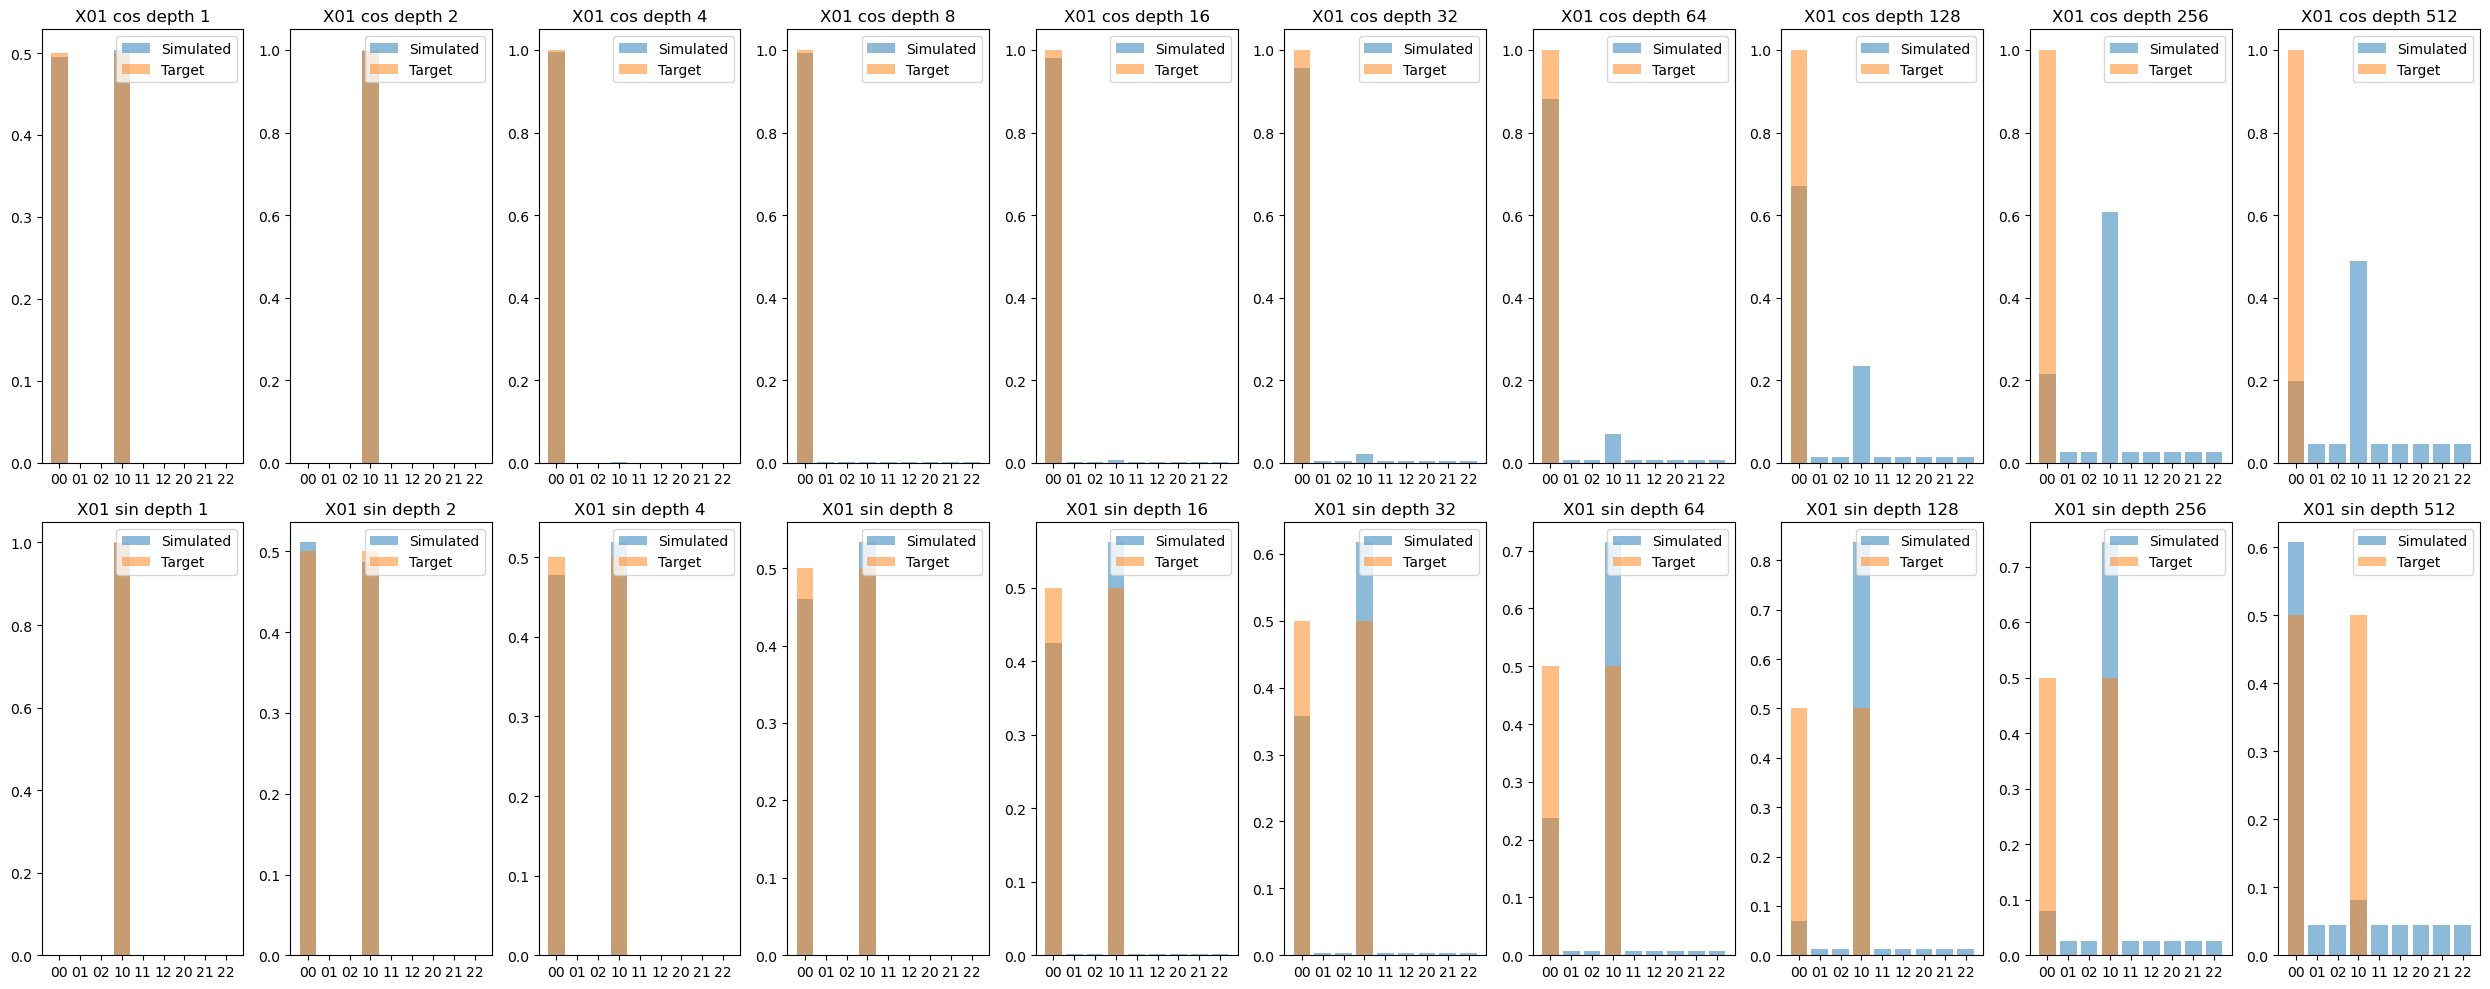

<Figure size 640x480 with 0 Axes>

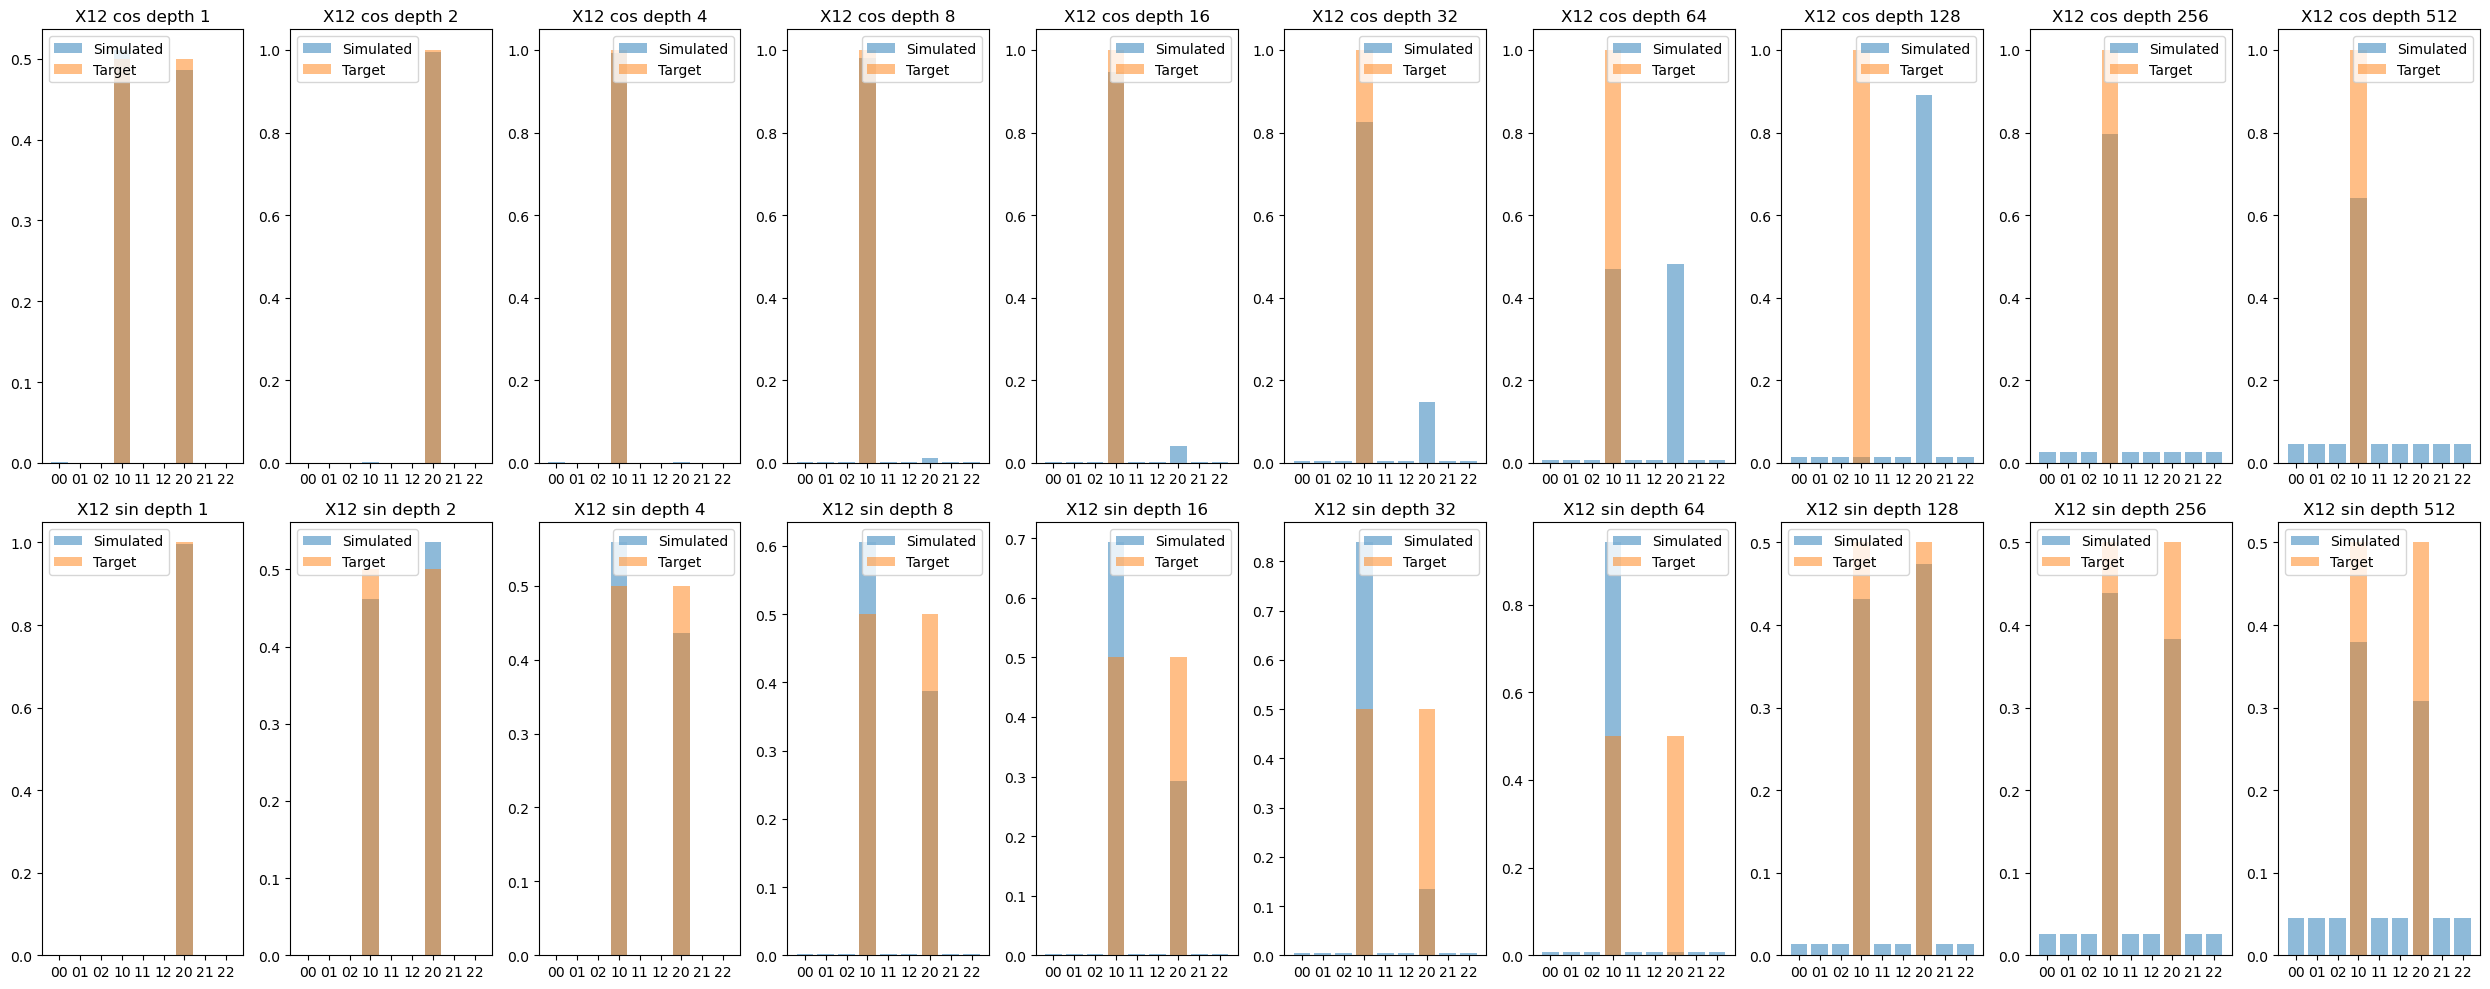

<Figure size 640x480 with 0 Axes>

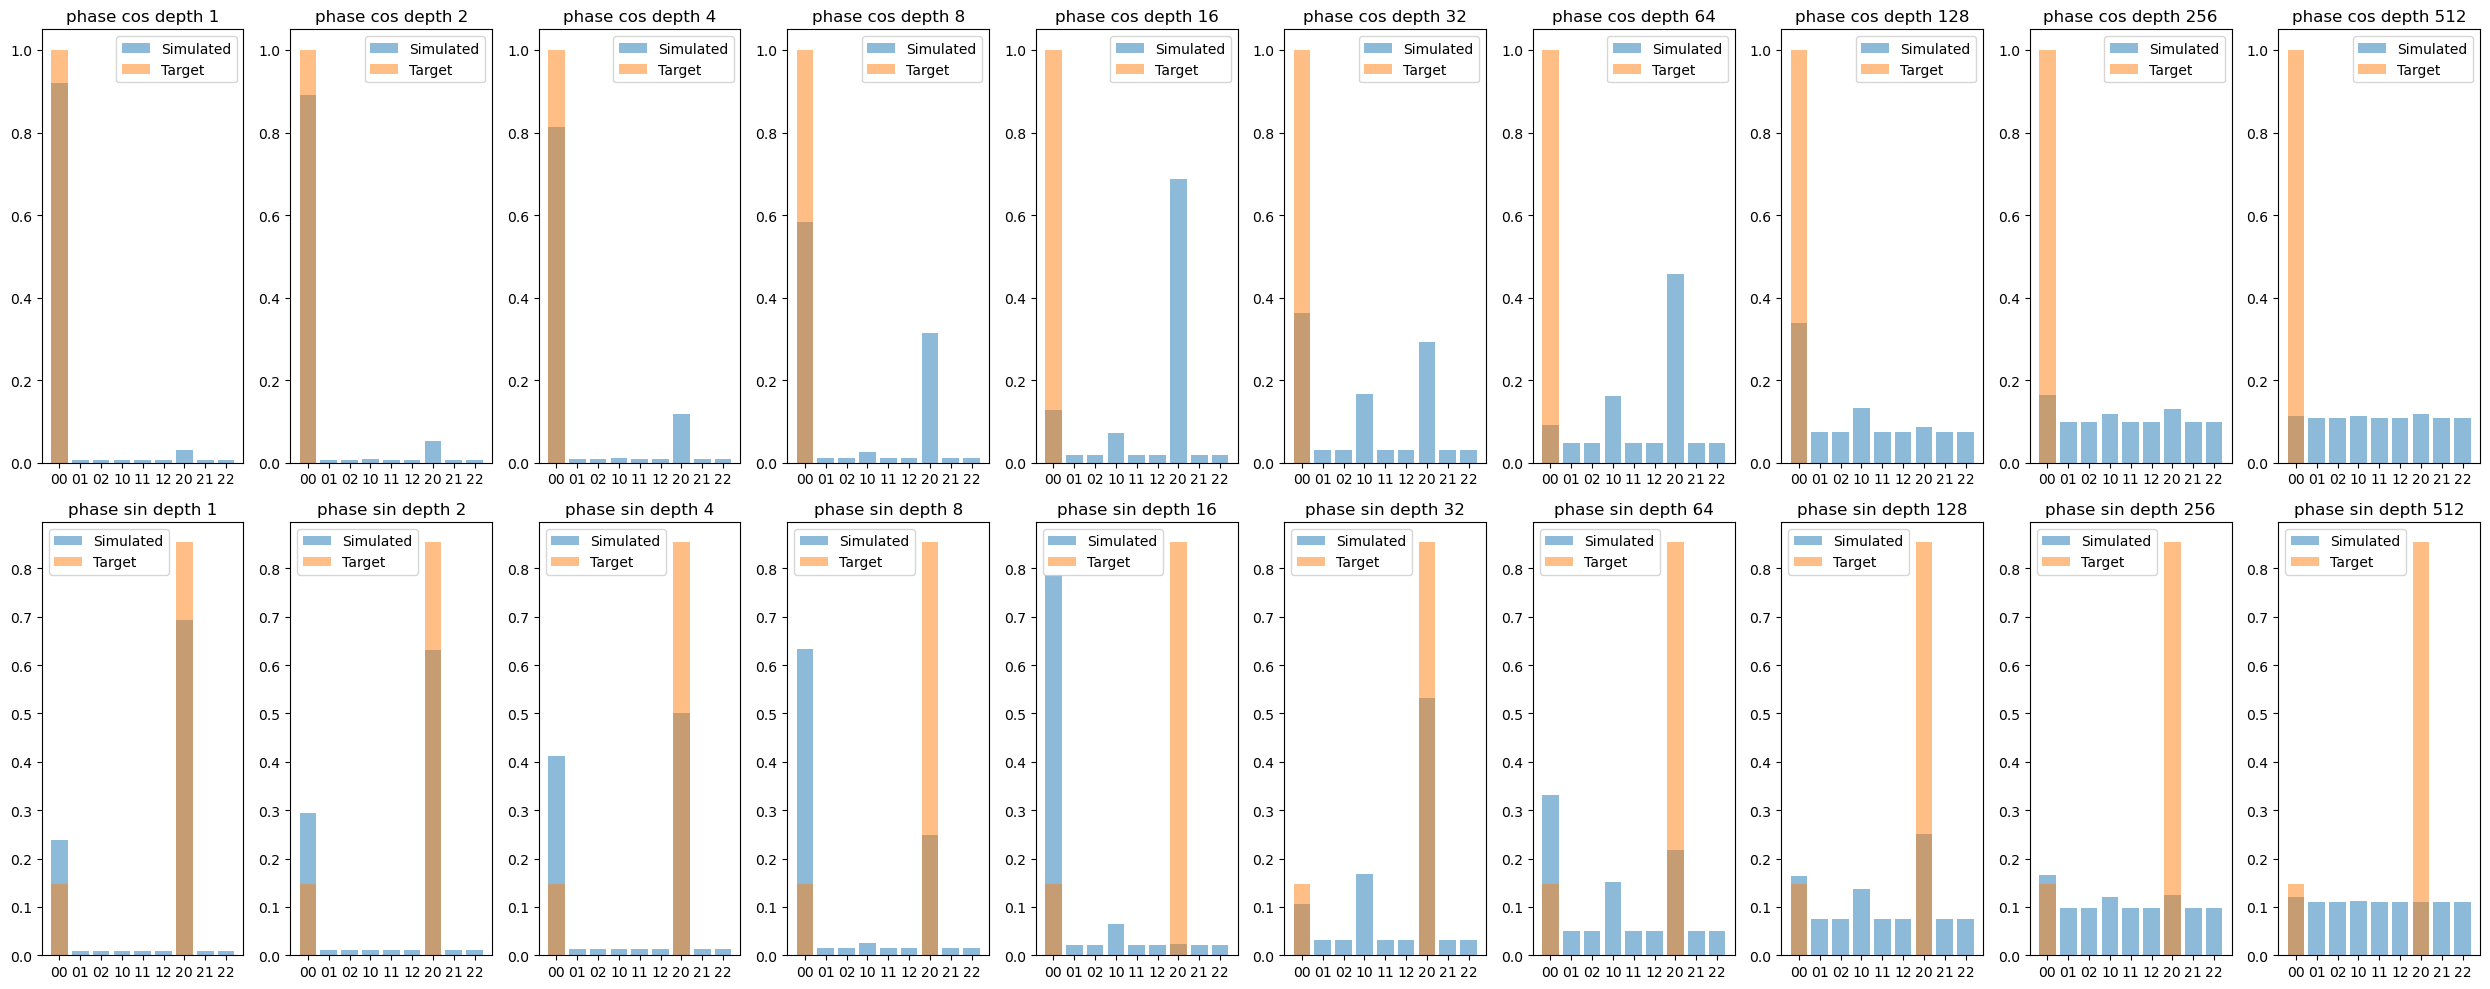

<Figure size 640x480 with 0 Axes>

In [774]:
plot_edesign_probability_from_model_and_target(edesign, depths, model, target_model)

# 2 single-qutrit  

In [900]:
circ_Y01_Q1 = [('Gz_01_Q1', 'Q1')] + [('Gx_01_Q1', 'Q1')] + [('Gz_01_Q1', 'Q1')]*3
circ_Y12_Q1 = [('Gz_12_Q1', 'Q1')] + [('Gx_12_Q1', 'Q1')] + [('Gz_12_Q1', 'Q1')]*3

circ_X01_Q1_inv = [('Gx_01_Q1', 'Q1')]*7
circ_X12_Q1_inv = [('Gx_12_Q1', 'Q1')]*7
circ_Y01_Q1_inv = circ_Y01_Q1*7
circ_Y12_Q1_inv = circ_Y12_Q1*7

fiducial_prep_dict = {
    'id' : [],
    'X01_Q1_cos_prep': [], 
    'X01_Q1_sin_prep': [], 
    'X12_Q1_cos_prep': [('Gx_01_Q1', 'Q1'), ('Gx_01_Q1', 'Q1')],
    'X12_Q1_sin_prep': [('Gx_01_Q1', 'Q1'), ('Gx_01_Q1', 'Q1')],
    'phase_Q1_cos_prep': [('Gx_01_Q1', 'Q1'), ('Gx_01_Q1', 'Q1')] + [('Gx_12_Q1', 'Q1')] + circ_Y01_Q1,
    'phase_Q1_sin_prep': [('Gx_01_Q1', 'Q1'), ('Gx_01_Q1', 'Q1')] + [('Gx_12_Q1', 'Q1')] + circ_Y01_Q1,
}

fiducial_meas_dict = {
    'id' : [],
    'X01_Q1_cos_meas': [], 
    'X01_Q1_sin_meas': [('Gx_01_Q1', 'Q1'),],
    'X12_Q1_cos_meas': [],
    'X12_Q1_sin_meas': [('Gx_12_Q1', 'Q1'),],
    'phase_Q1_cos_meas': circ_Y01_Q1_inv + circ_X12_Q1_inv + [('Gx_01_Q1', 'Q1')]*6,
    'phase_Q1_sin_meas': circ_Y01_Q1_inv + circ_Y12_Q1_inv + [('Gx_01_Q1', 'Q1')]*6, 
}

def make_1qt_fiducials(qid):
    prep_dict = {
        'id' : [],
        'X01_cos_prep': [], 
        'X01_sin_prep': [], 
        'X12_cos_prep': [(f'Gx_01_{qid}', qid), (f'Gx_01_{qid}', qid)],
        'X12_sin_prep': [(f'Gx_01_{qid}', qid), (f'Gx_01_{qid}', qid)],
        'phase_cos_prep': [(f'Gx_01_{qid}', qid), (f'Gx_01_{qid}', qid)] + [(f'Gx_12_{qid}', qid)] + circ_Y01_Q1,
        'phase_sin_prep': [(f'Gx_01_{qid}', qid), (f'Gx_01_{qid}', qid)] + [(f'Gx_12_{qid}', qid)] + circ_Y01_Q1,
    }

    meas_dict = {
        'id' : [],
        'X01_cos_meas': [], 
        'X01_sin_meas': [(f'Gx_01_{qid}', qid),],
        'X12_cos_meas': [],
        'X12_sin_meas': [(f'Gx_12_{qid}', qid),],
        'phase_cos_meas': circ_Y01_Q1_inv + circ_X12_Q1_inv + [(f'Gx_01_{qid}', qid)]*6,
        'phase_sin_meas': circ_Y01_Q1_inv + circ_Y12_Q1_inv + [(f'Gx_01_{qid}', qid)]*6, 
    }

    return prep_dict, meas_dict



In [901]:
def make_rpe_circuit(gate, prep_circ, meas_circ, depth):
    return Circuit(['rho0'] + prep_circ + gate*depth + meas_circ + ['Mdefault'], line_labels=['Q1', 'Q2'])

def make_two_qutrit_rpe_edesign_nocz(qids, depths):

    # make circuit dict
    circuit_dict = { qid : {
        'X01' : {'cos': [], 'sin': []},
        'X01' : {'cos': [], 'sin': []},
        'X12' : {'cos': [], 'sin': []},
        'X12' : {'cos': [], 'sin': []},
        'phase' : {'cos': [], 'sin': []},
        'phase' : {'cos': [], 'sin': []},
    } for qid in qids}

    # make fiducials
    fid_prep_dict = {
        qid : make_1qt_fiducials(qid)[0] for qid in qids
    }
    fid_meas_dict = {
        qid : make_1qt_fiducials(qid)[1] for qid in qids
    }

    for qid in qids:
        for depth in depths:
            circuit_dict[qid]['X01']['cos'].append(make_rpe_circuit([(f'Gx_01_{qid}', qid)], fid_prep_dict[qid]['X01_cos_prep'], fid_meas_dict[qid]['X01_cos_meas'], depth))
            circuit_dict[qid]['X01']['sin'].append(make_rpe_circuit([(f'Gx_01_{qid}', qid)], fid_prep_dict[qid]['X01_sin_prep'], fid_meas_dict[qid]['X01_sin_meas'], depth))
            circuit_dict[qid]['X12']['cos'].append(make_rpe_circuit([(f'Gx_12_{qid}', qid)], fid_prep_dict[qid]['X12_cos_prep'], fid_meas_dict[qid]['X12_cos_meas'], depth))
            circuit_dict[qid]['X12']['sin'].append(make_rpe_circuit([(f'Gx_12_{qid}', qid)], fid_prep_dict[qid]['X12_sin_prep'], fid_meas_dict[qid]['X12_sin_meas'], depth))
            circuit_dict[qid]['phase']['cos'].append(make_rpe_circuit([(f'Gx_01_{qid}', qid)]*8, fid_prep_dict[qid]['phase_cos_prep'], fid_meas_dict[qid]['phase_cos_meas'], depth))
            circuit_dict[qid]['phase']['sin'].append(make_rpe_circuit([(f'Gx_01_{qid}', qid)]*8, fid_prep_dict[qid]['phase_sin_prep'], fid_meas_dict[qid]['phase_sin_meas'], depth))
            
    
    return circuit_dict

def edesign_to_circuit_list(edesign):
    circuits = []
    for qid in edesign.keys():
        for etype in edesign[qid].keys():
            for mtype in edesign[qid][etype].keys():
                for circuit in edesign[qid][etype][mtype]:
                    circuits.append(circuit)
    return pygsti.tools.remove_duplicates(circuits)

In [905]:
len(circ_list)

92

In [934]:
def estimate_phases_from_ds_nocz(dataset, edesign, depths):
    estimates = {}
    
    # X01 overrotation on Q1
    try:
        phase_estimates, lgg = estimate_phase_from_dataset(dataset, edesign['Q1']['X01']['cos'], ['00'], ['10'], edesign['Q1']['X01']['sin'], ['00'], ['10'], depths)
        last_good_x01_q1_phase = phase_estimates[lgg]
        phase_error = -last_good_x01_q1_phase - np.pi/2
        rectified_phase_error = rectify_phase(phase_error)
        x01_q1_overrot_estimate = rectified_phase_error
        estimates['x01_q1_overrot'] = x01_q1_overrot_estimate
    except:
        estimates['x01_q1_overrot'] = None
        print('x01_q1_overrot failed')

    # X12 overrotation on Q1
    try:
        phase_estimates, lgg = estimate_phase_from_dataset(dataset, edesign['Q1']['X12']['cos'], ['10'], ['20'], edesign['Q1']['X12']['sin'], ['10'], ['20'], depths)
        last_good_x12_q1_phase = phase_estimates[lgg]
        phase_error = -last_good_x12_q1_phase - np.pi/2
        rectified_phase_error = rectify_phase(phase_error)
        x12_q1_overrot_estimate = rectified_phase_error
        estimates['x12_q1_overrot'] = x12_q1_overrot_estimate
    except:
        estimates['x12_q1_overrot'] = None
        print('x12_q1_overrot failed')

    # X01 overrotation on Q2
    try:
        phase_estimates, lgg = estimate_phase_from_dataset(dataset, edesign['Q2']['X01']['cos'], ['00'], ['01'], edesign['Q2']['X01']['sin'], ['00'], ['01'], depths)
        last_good_x01_q2_phase = phase_estimates[lgg]
        phase_error = -last_good_x01_q2_phase - np.pi/2
        rectified_phase_error = rectify_phase(phase_error)
        x01_q2_overrot_estimate = rectified_phase_error
        estimates['x01_q2_overrot'] = x01_q2_overrot_estimate
    except:
        estimates['x01_q2_overrot'] = None
        print('x01_q1_overrot failed')

    # X12 overrotation on Q2
    try:
        phase_estimates, lgg = estimate_phase_from_dataset(dataset, edesign['Q2']['X12']['cos'], ['01'], ['02'], edesign['Q2']['X12']['sin'], ['01'], ['02'], depths)
        last_good_x12_q2_phase = phase_estimates[lgg]
        phase_error = -last_good_x12_q2_phase - np.pi/2
        rectified_phase_error = rectify_phase(phase_error)
        x12_q2_overrot_estimate = rectified_phase_error
        estimates['x12_q2_overrot'] = x12_q2_overrot_estimate
    except:
        estimates['x12_q2_overrot'] = None
        print('x12_q1_overrot failed')

    # phase error on Q1
    try:
        phase_estimates, lgg = estimate_phase_from_dataset(dataset, edesign['Q1']['phase']['cos'], ['00'], ['20'], edesign['Q1']['phase']['sin'], ['00'], ['20'], depths)
        last_good_phase_raw = phase_estimates[lgg]
        last_good_phase_rectified = rectify_phase(last_good_phase_raw)
        phase_error_estimate = (-last_good_phase_rectified + 4*x01_q1_overrot_estimate)/12
        estimates['phase_q1_error'] = phase_error_estimate
    except:
        estimates['phase_q1_error'] = None
        print('phase_q1_error failed')

    # phase error on Q2
    try:
        phase_estimates, lgg = estimate_phase_from_dataset(dataset, edesign['Q2']['phase']['cos'], ['00'], ['20'], edesign['Q2']['phase']['sin'], ['00'], ['20'], depths)
        last_good_phase_raw = phase_estimates[lgg]
        last_good_phase_rectified = rectify_phase(last_good_phase_raw)
        phase_error_estimate = (-last_good_phase_rectified + 4*x01_q2_overrot_estimate)/12
        estimates['phase_q2_error'] = phase_error_estimate

    except:
        estimates['phase_q2_error'] = None
        print('phase_q2_error failed')

    return estimates

In [935]:
def plot_edesign_probability_from_model_and_target_2qt(edesign, depths, model, target_model):
    for qid in edesign.keys():
        for etype in edesign[qid].keys():
            fig, ax = plt.subplots(2, len(depths), figsize=(25, 10))
            for m_idx, mtype in enumerate(edesign[qid][etype].keys()):
                for depth_idx, circuit in enumerate(edesign[qid][etype][mtype]):
                    probs = model.probabilities(circuit)
                    target_probs = target_model.probabilities(circuit)
                    plot_outcome_dist_2qt(probs, target_probs, ax[m_idx, depth_idx])
                    ax[m_idx, depth_idx].set_title(f'{qid} {etype} {mtype} depth {depths[depth_idx]}')
            plt.tight_layout()
            plt.show()
            plt.figure()

In [941]:
def estimate_dict_to_vec(estimates):
    vec = np.zeros(14)
    vec[0] = estimates['x01_q1_overrot']
    vec[1] = estimates['phase_q1_error']
    vec[2] = estimates['x12_q1_overrot']
    vec[3] = estimates['x01_q2_overrot']
    vec[4] = estimates['phase_q2_error']
    vec[5] = estimates['x12_q2_overrot']
    return vec

In [946]:
# make a random error vec and a model
x = random_error_vector(0.001, 0.001)
model = make_model(x, 0.001, 0.00)

In [947]:
# make the edesign and dataset
depths = [2**i for i in range(8)]
edesign = make_two_qutrit_rpe_edesign_nocz(['Q1', 'Q2'], depths)
circ_list = edesign_to_circuit_list(edesign)
ds = pygsti.data.simulate_data(model, circ_list, num_samples=1000, seed=2021)

In [948]:
# estimate
estimates = estimate_phases_from_ds_nocz(ds, edesign, depths)
evec = estimate_dict_to_vec(estimates)
print(estimates)

{'x01_q1_overrot': -0.0015002592249100388, 'x12_q1_overrot': -0.002485002635650879, 'x01_q2_overrot': -0.08573376392468823, 'x12_q2_overrot': -0.00912438793975312, 'phase_q1_error': -0.03583906307766135, 'phase_q2_error': -0.0290971315115303}


In [949]:
print(x, evec)

[-0.00151137 -0.03569864 -0.00253012 -0.08551812  0.0475157  -0.00921748
 -0.00620581  0.02294139 -0.04813218 -0.04417917  0.00879459 -0.0061142
 -0.04065101  0.03535507] [-0.00150026 -0.03583906 -0.002485   -0.08573376 -0.02909713 -0.00912439
  0.          0.          0.          0.          0.          0.
  0.          0.        ]


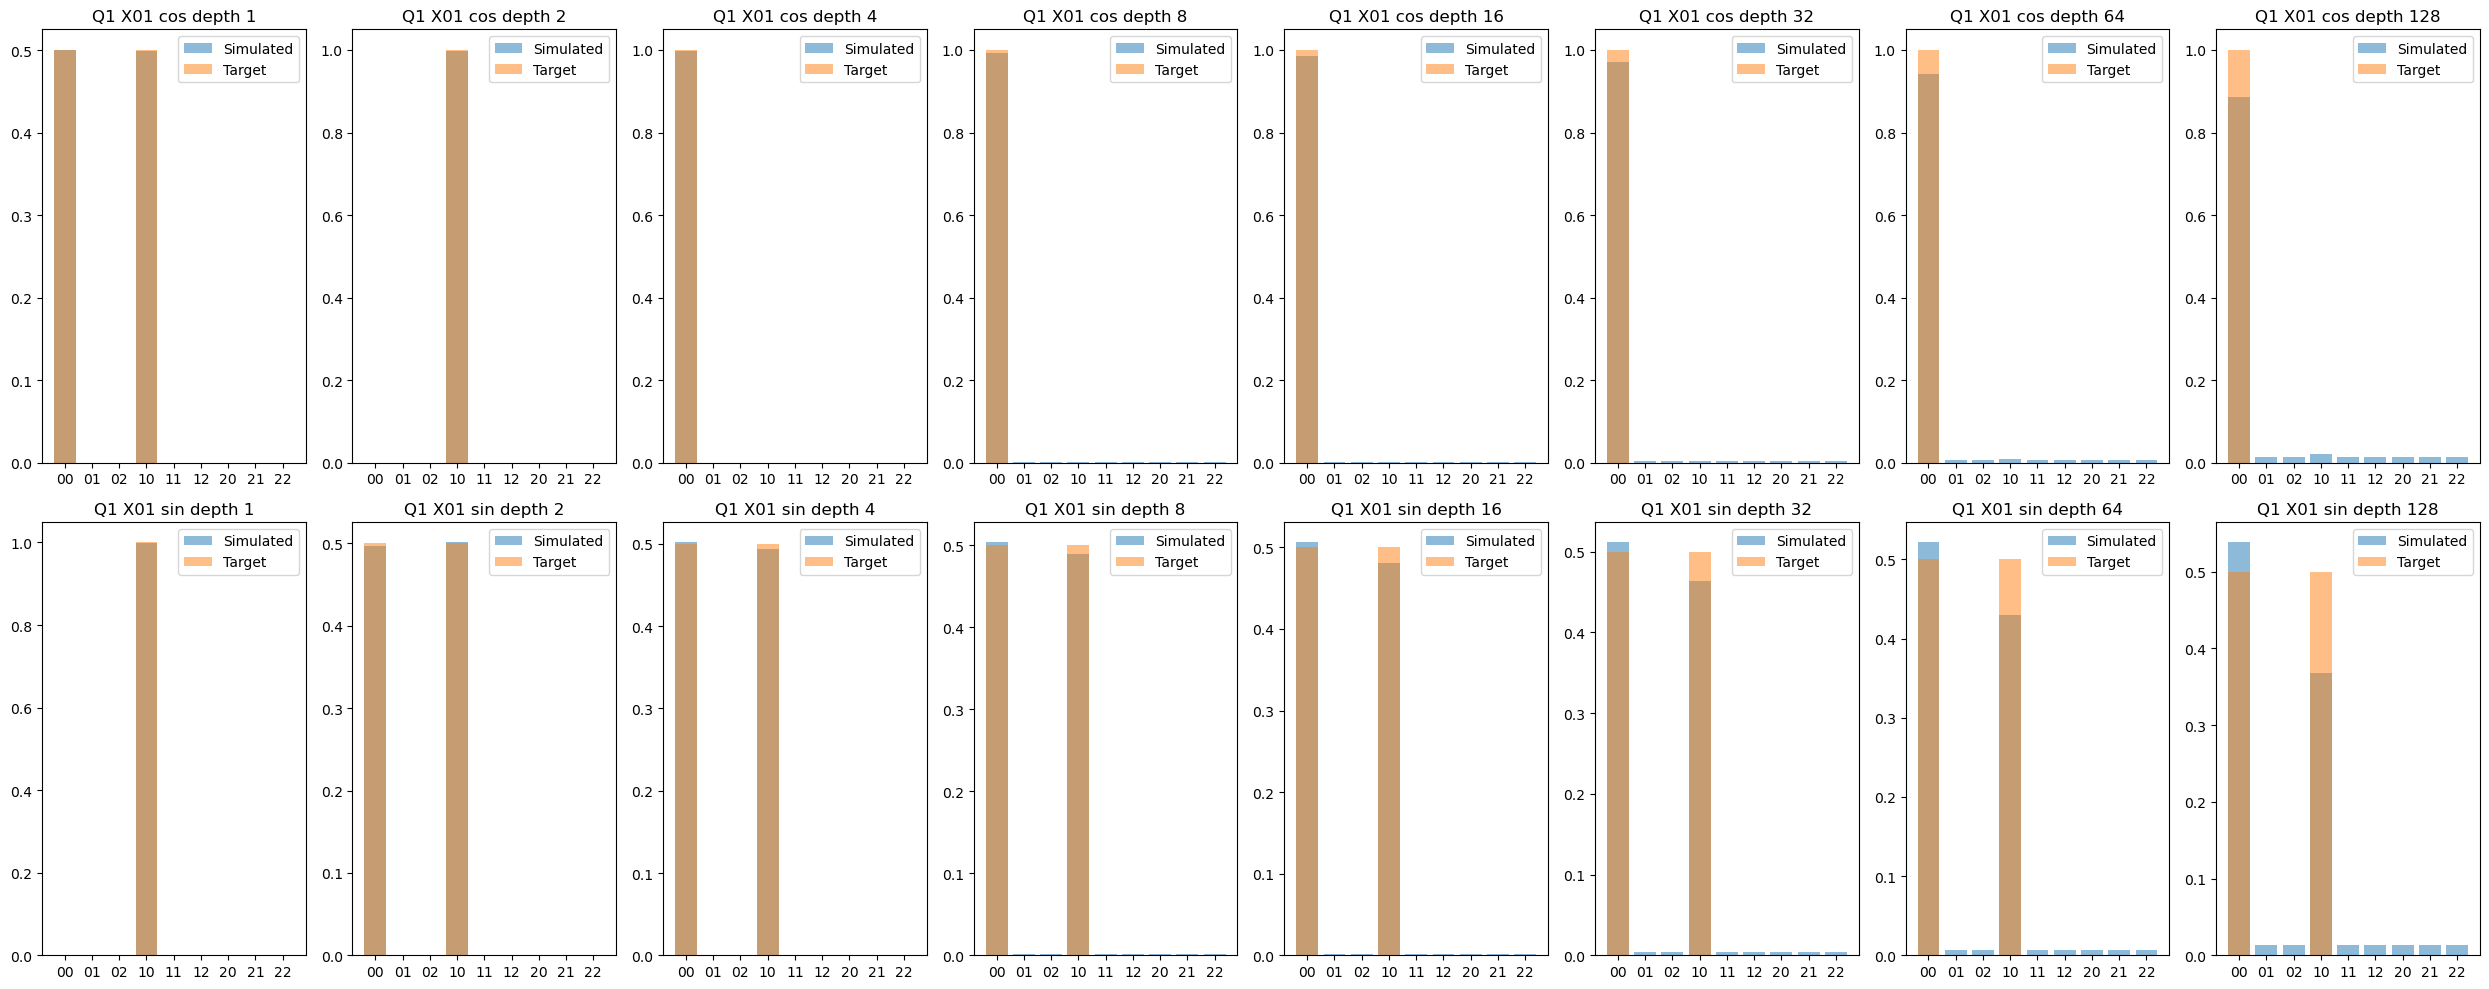

<Figure size 640x480 with 0 Axes>

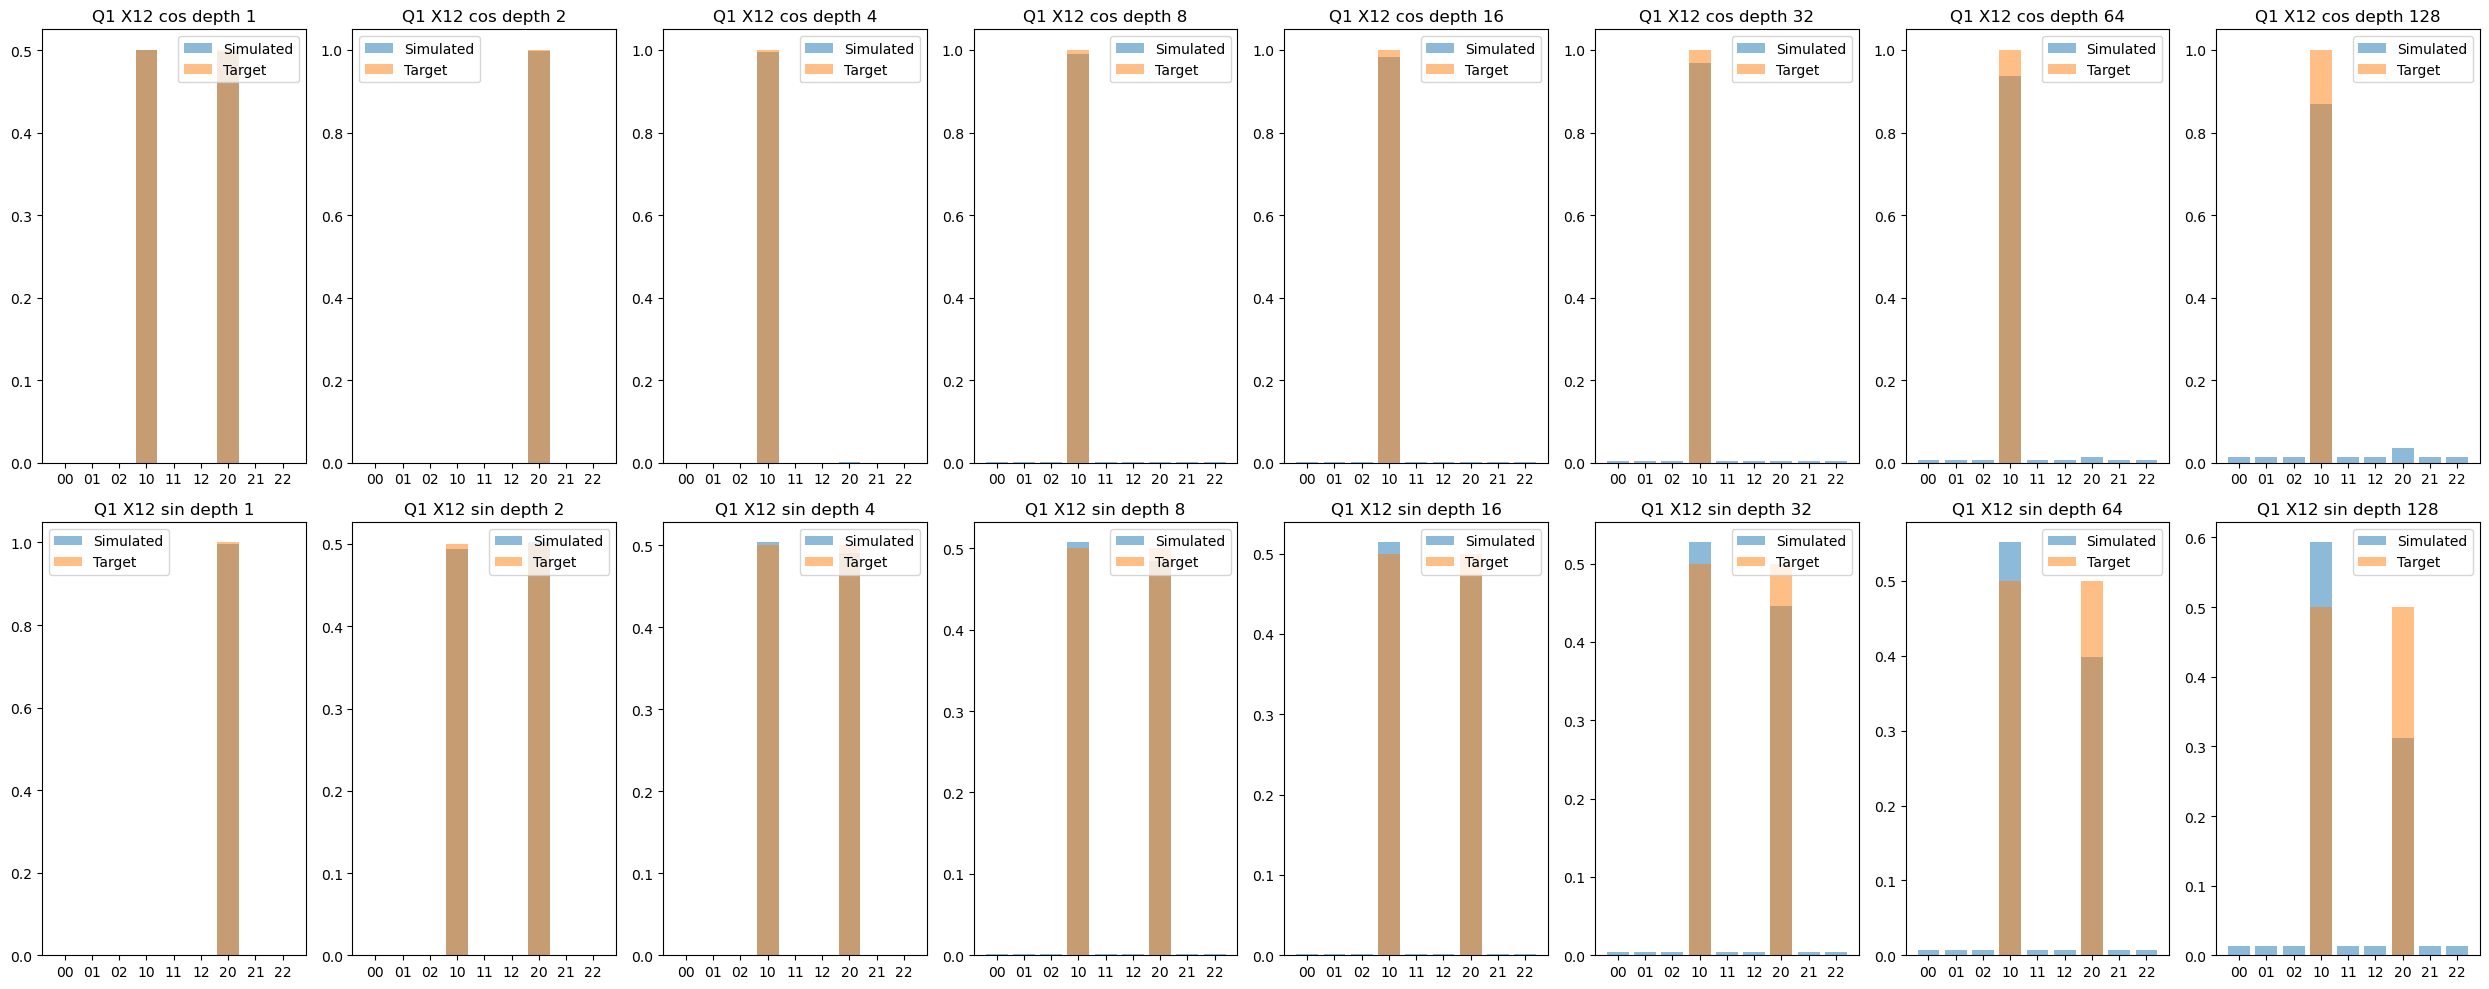

<Figure size 640x480 with 0 Axes>

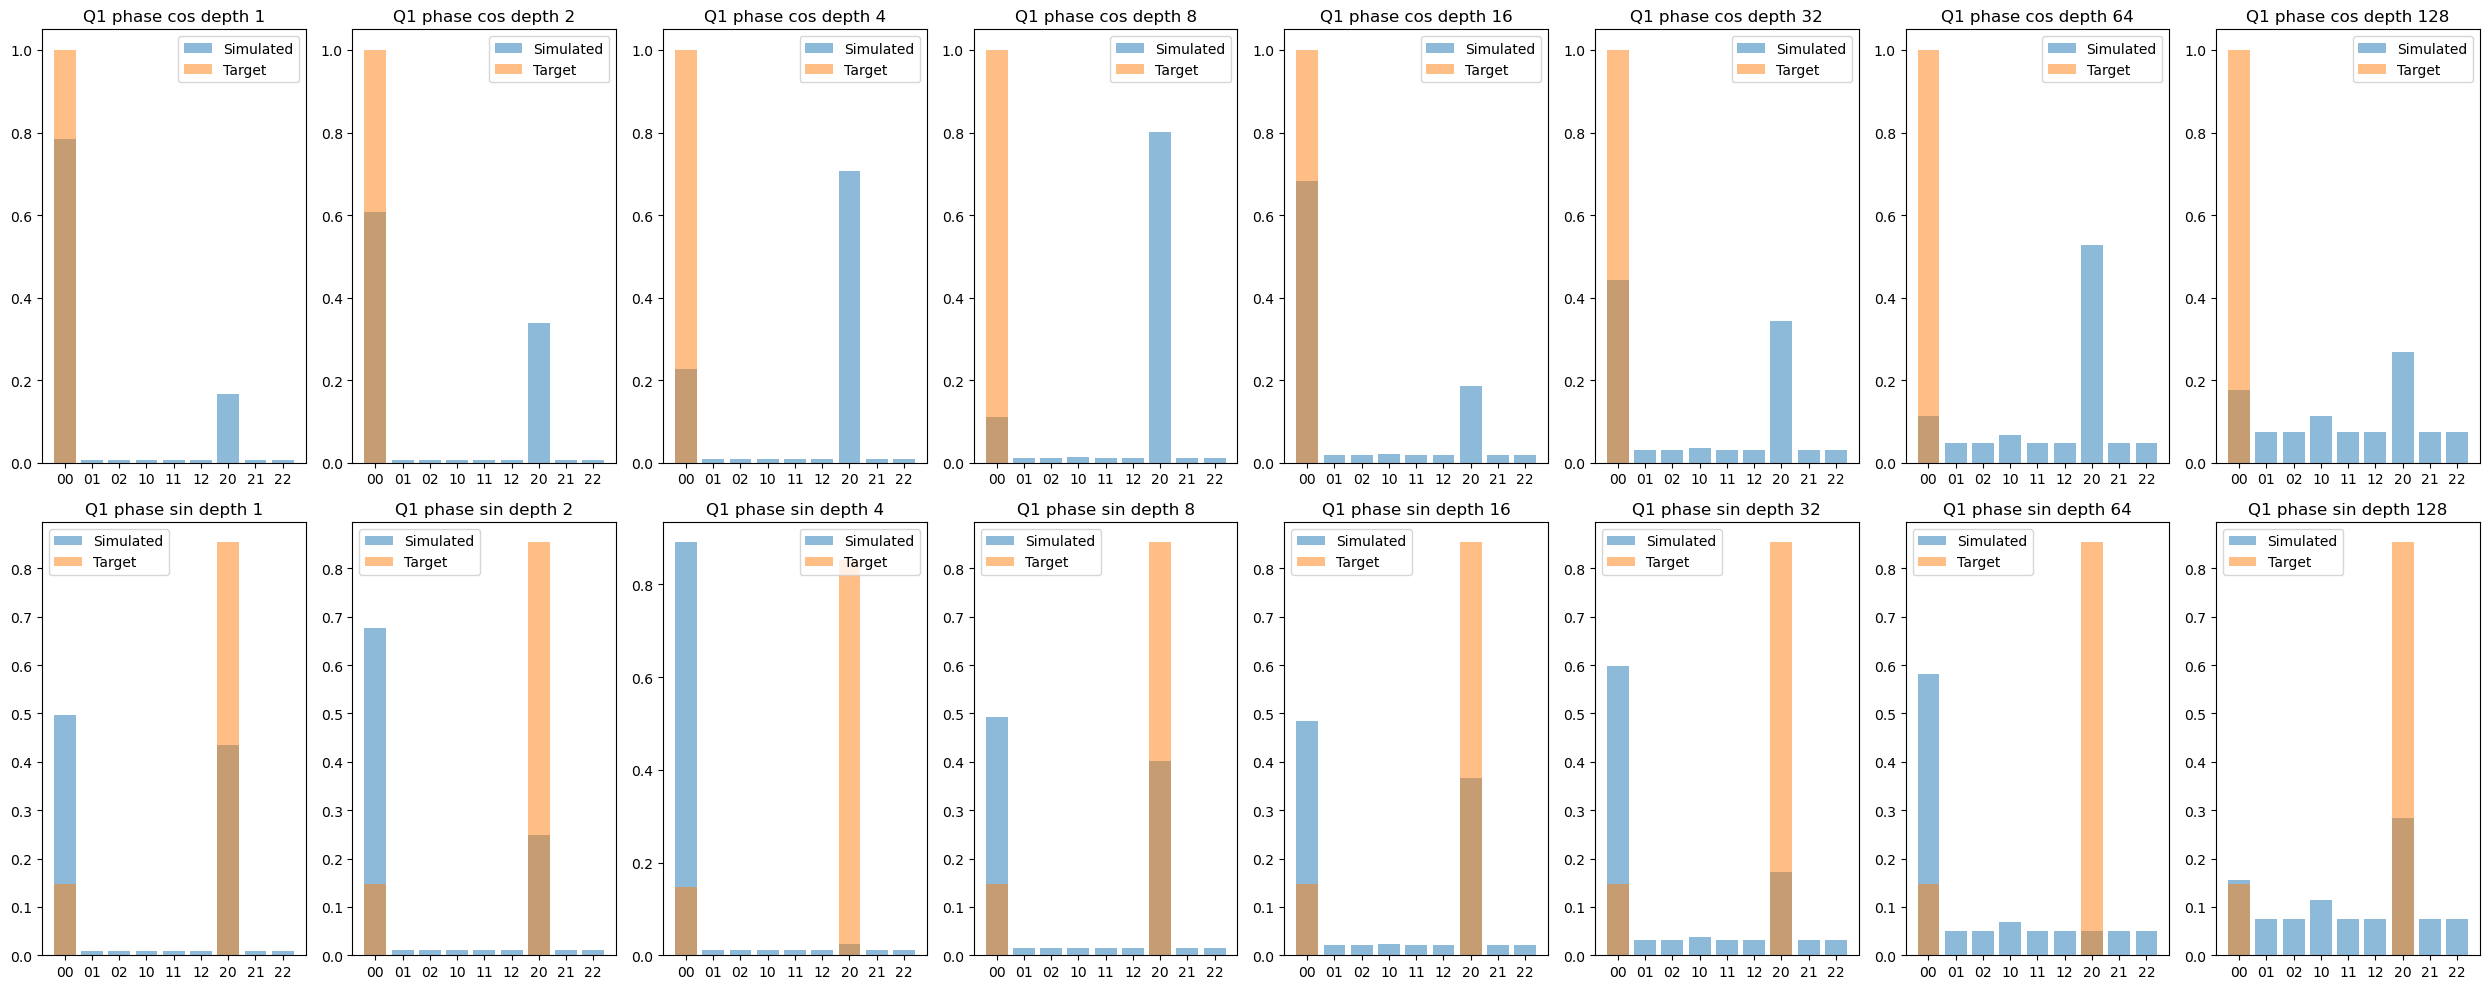

<Figure size 640x480 with 0 Axes>

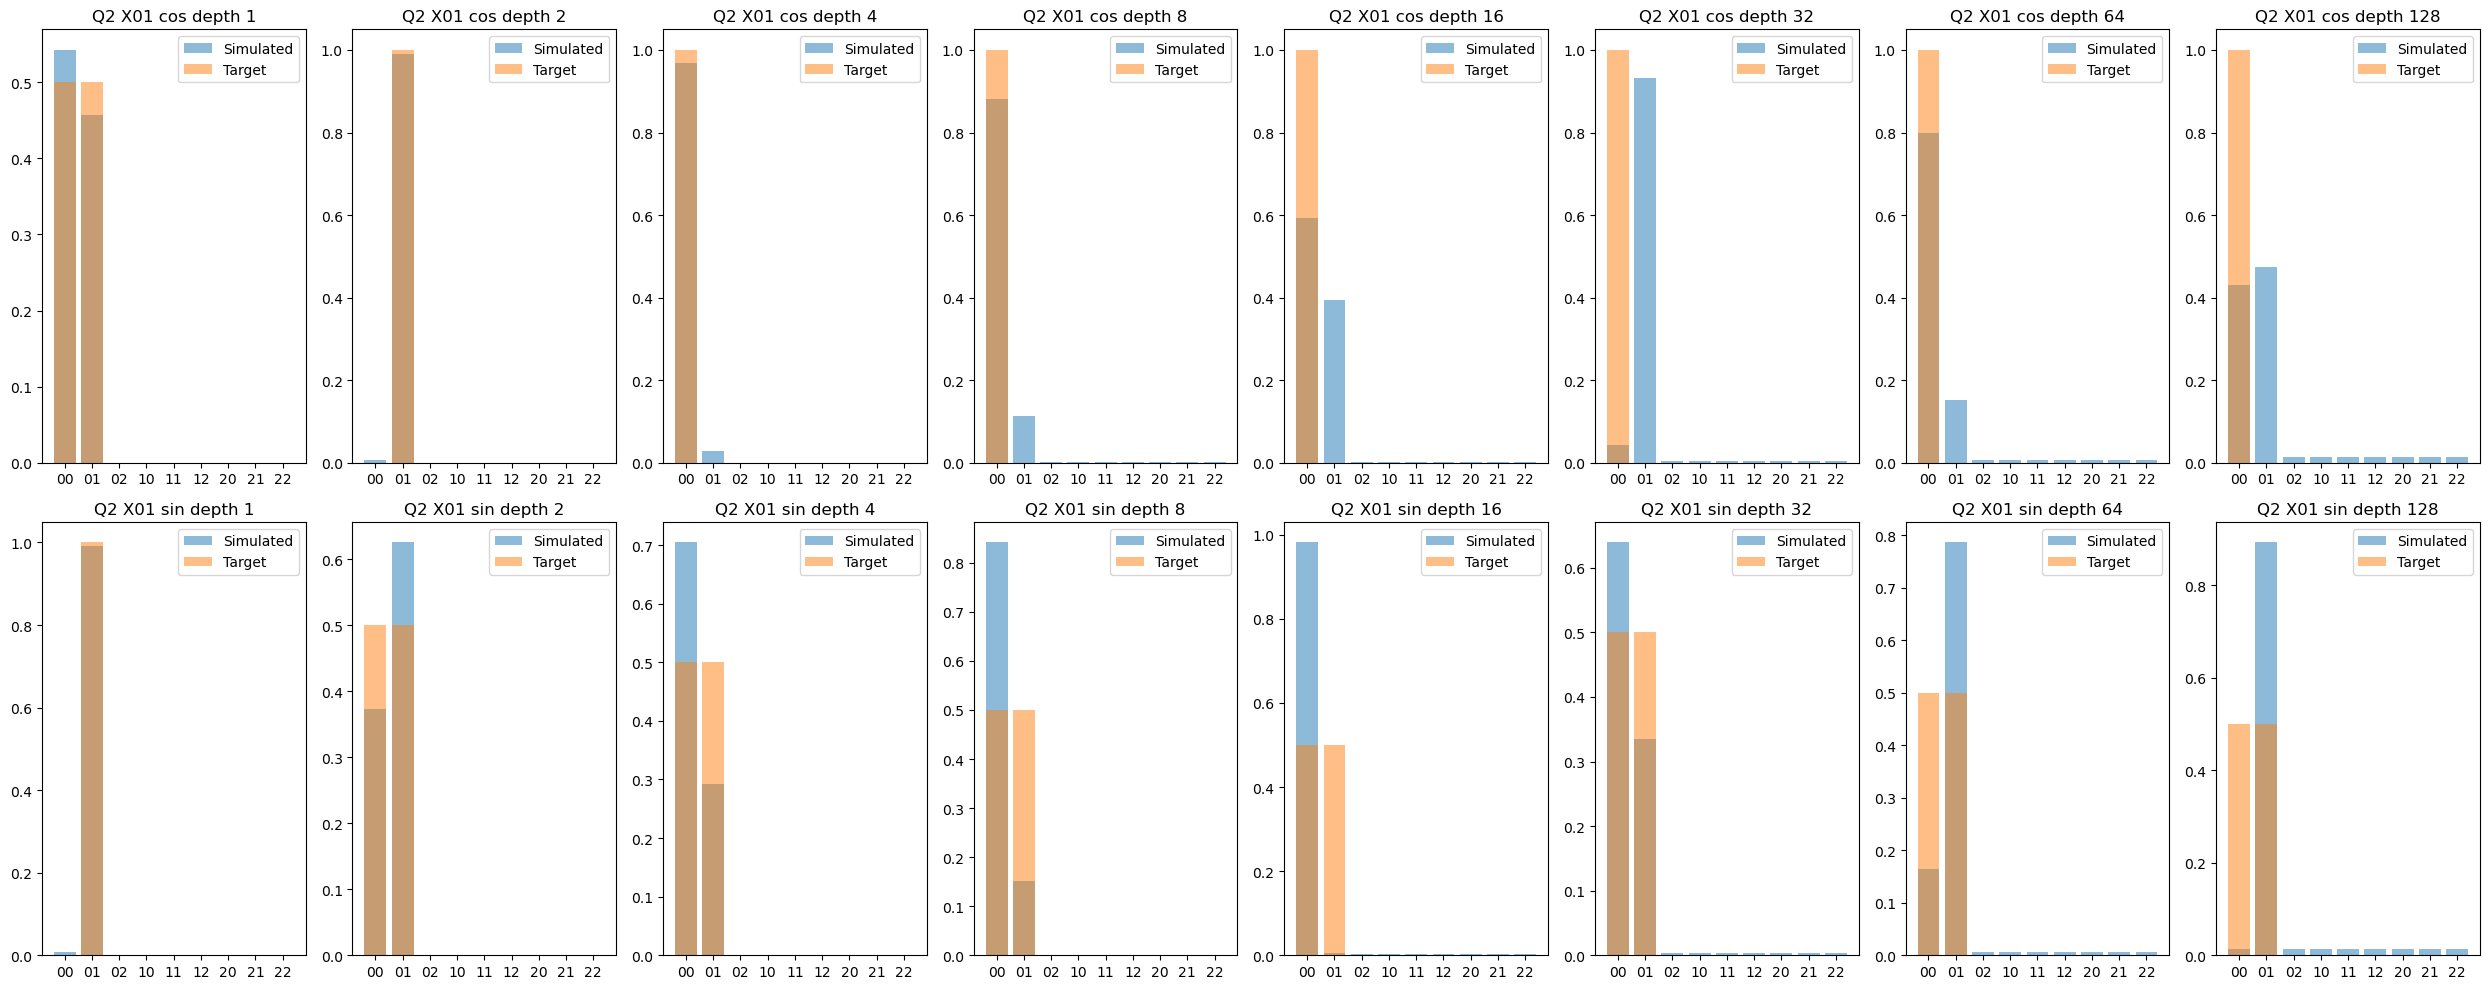

<Figure size 640x480 with 0 Axes>

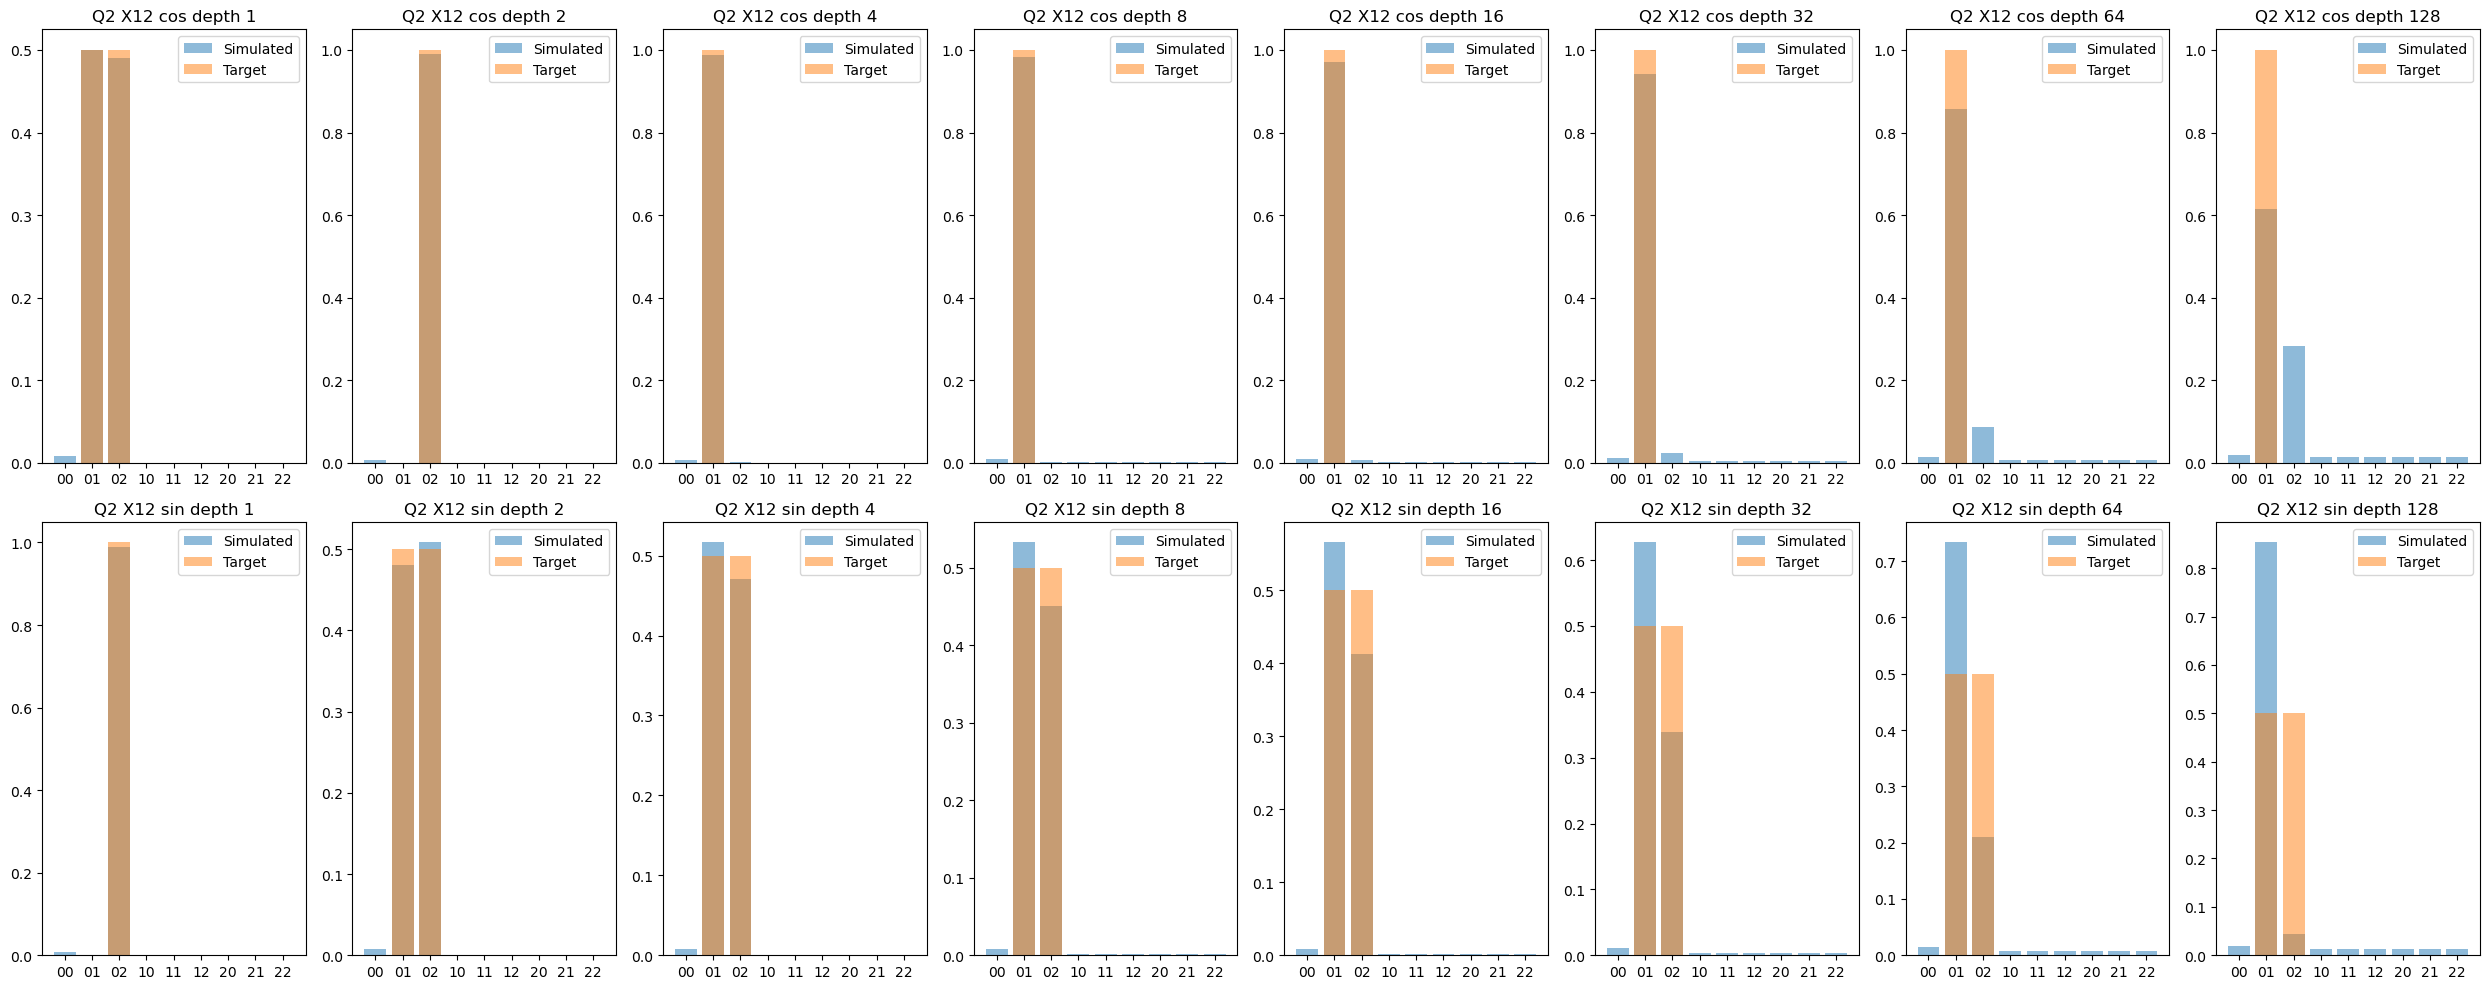

<Figure size 640x480 with 0 Axes>

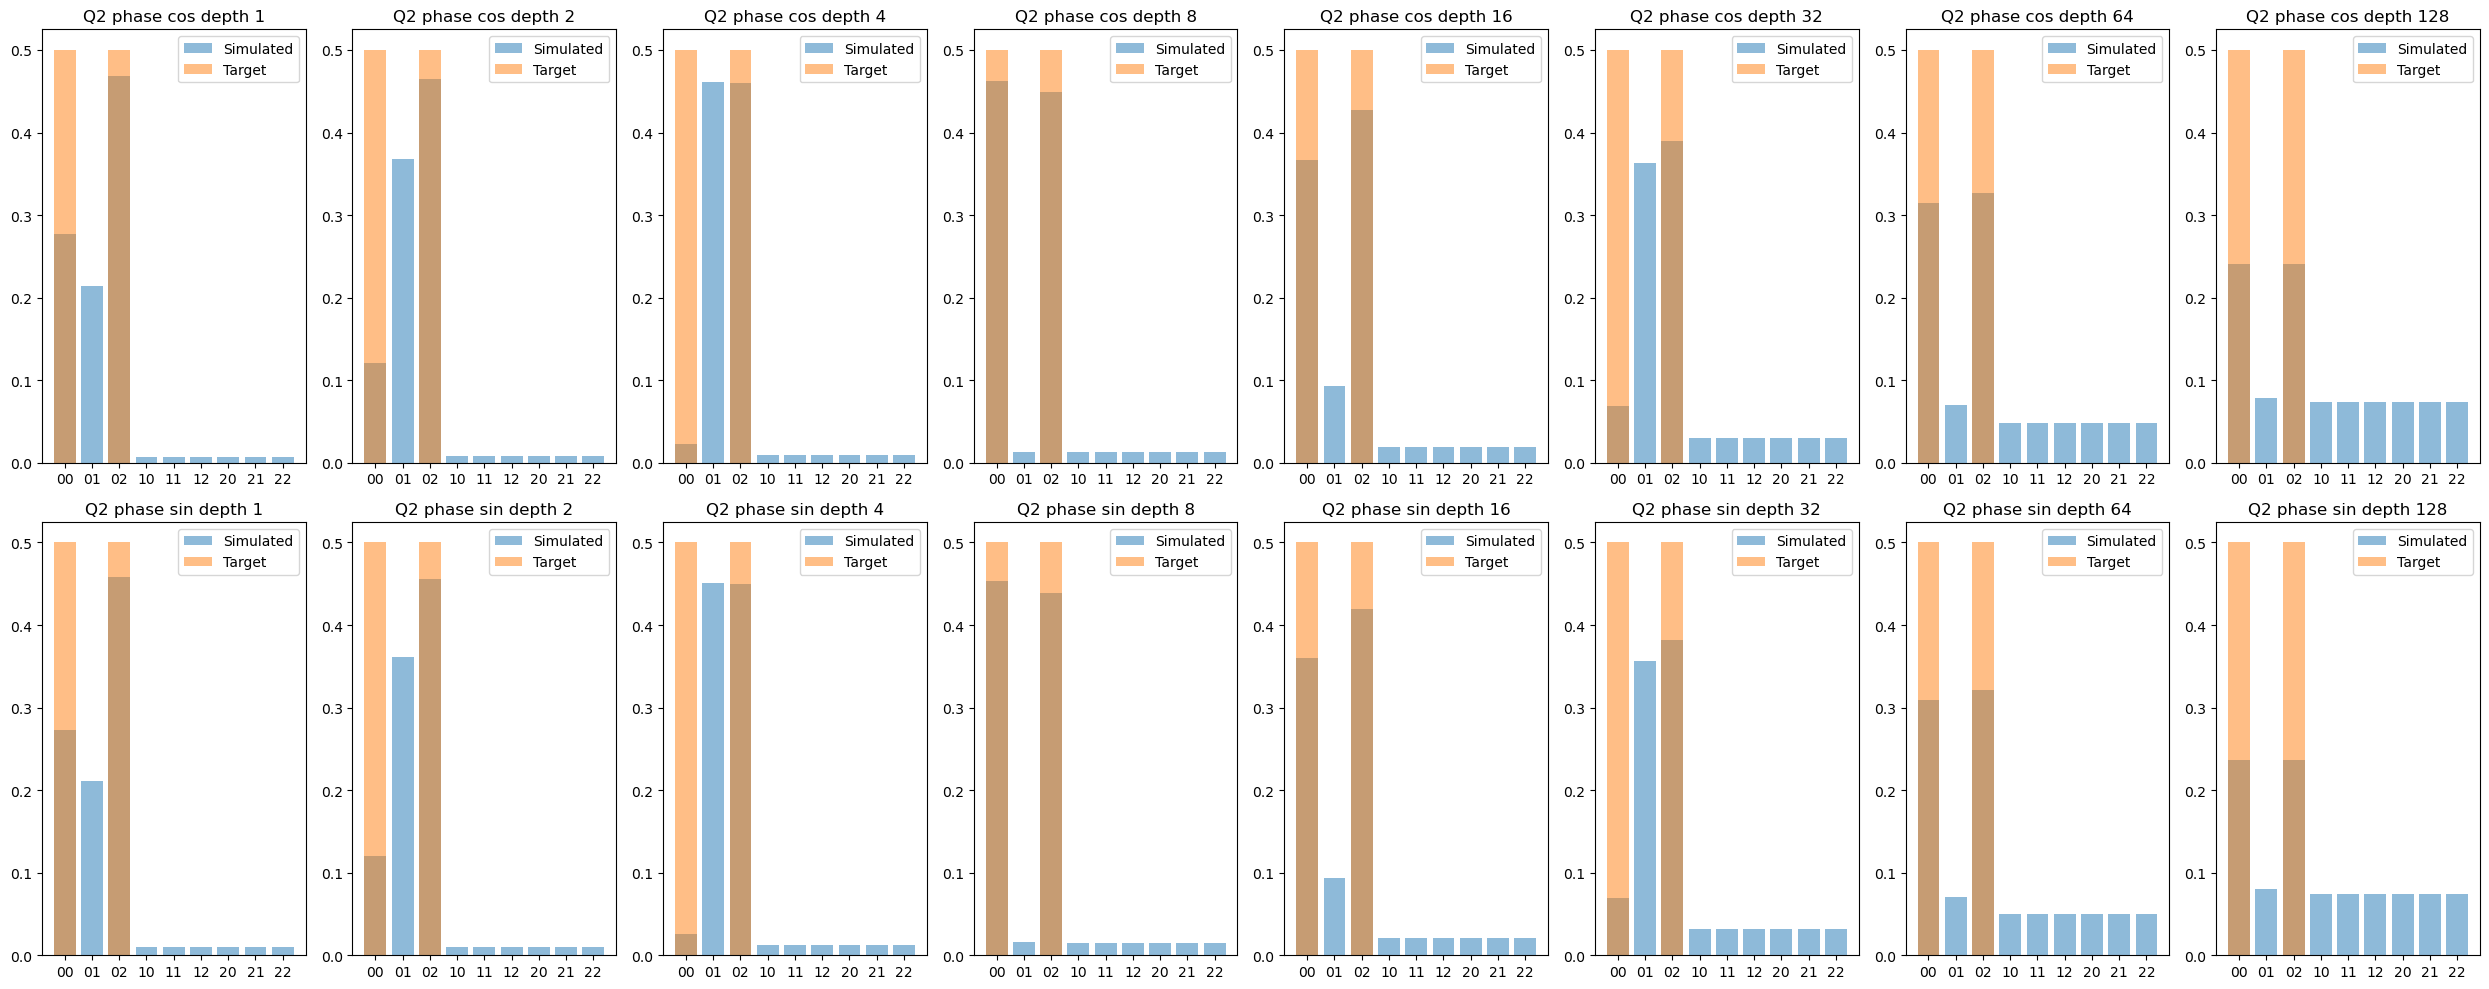

<Figure size 640x480 with 0 Axes>

In [950]:
plot_edesign_probability_from_model_and_target_2qt(edesign, depths, model, target_model)

# Error scaling

In [1054]:
x = random_error_vector(0.001, 0.001)
x_hats = []
model = make_model(x, 0.001, 0.001)

max_depth_powers = range(1, 10)
for mdp in max_depth_powers:
    depths = [2**i for i in range(mdp)]
    edesign = make_two_qutrit_rpe_edesign_nocz(['Q1', 'Q2'], depths)
    circ_list = edesign_to_circuit_list(edesign)
    ds = pygsti.data.simulate_data(model, circ_list, num_samples=1000, seed=2021)
    estimates = estimate_phases_from_ds_nocz(ds, edesign, depths)
    x_hats.append(estimate_dict_to_vec(estimates))

In [1055]:
x_hats

[array([ 0.105513  , -0.1304763 ,  0.01311744, -0.07016603, -0.08896001,
        -0.05427283,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ]),
 array([ 0.12821554, -0.06190155,  0.00252778, -0.05840911, -0.05200532,
        -0.0337526 ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ]),
 array([ 0.10751143, -0.07553447,  0.00842369, -0.05726052, -0.03529921,
        -0.01798875,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ]),
 array([ 0.08948485, -0.07738414,  0.00786575, -0.04798003, -0.01184364,
        -0.02688444,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ]),
 array([ 0.08658709, -0.07745556,  0.01002693, -0.04462058, -0.03815313,
        -0.02553398,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  

In [1079]:
# # plot estimate error scaling with max depth power
# def plot_estimate_error_scaling(xtrue, xhats, max_depth_powers, axs=None):
#     if axs is None:
#         fig, axs = plt.subplots(len(xtrue), 1, figsize=(10, len(xtrue)*5))
#         axs_was_none = True
#     else:
#         axs_was_none = False
#     for idx, x in enumerate(xtrue):
#         errors = [np.abs(x - xhat[idx]) for xhat in xhats]
#         axs[idx].scatter(max_depth_powers, errors)
#         if axs_was_none is False:
#             axs[idx].set_xlabel('Max depth power')
#             axs[idx].set_ylabel('Error')
#             axs[idx].set_title(f'Error for x{idx}')
#     if axs_was_none is False:
#         plt.tight_layout()

# def plot_many_estimate_error_scaling(xtrue, xhat_vecs, max_depth_powers):
#     fig, axs = plt.subplots(len(xtrue), 1, figsize=(10, len(xtrue)*5))
#     for idx, xvec in enumerate(xhat_vecs):
#         plot_estimate_error_scaling(xtrue, xvec, max_depth_powers, axs=axs)
#     plt.tight_layout()
#     plt.show()

# plot estimate error scaling with max depth power
def plot_estimate_error_scaling(xtrue, xhats, max_depth_powers, axs=None):
    if axs is None:
        fig, axs = plt.subplots(len(xtrue), 1, figsize=(10, len(xtrue)*5))
        axs_was_none = True
    else:
        axs_was_none = False

    # Pre-calculate all errors
    all_errors = []
    for idx, x in enumerate(xtrue):
        errors = [np.abs(x - xhat[idx]) for xhat in xhats]
        all_errors.append(errors)

    # Now plot all at once
    for idx, errors in enumerate(all_errors):
        axs[idx].scatter(max_depth_powers, errors)
        if axs_was_none is False:
            axs[idx].set_xlabel('Max depth power')
            axs[idx].set_ylabel('Error')
            axs[idx].set_title(f'Error for x{idx}')
    if axs_was_none is False:
        plt.tight_layout()

def make_rpe_bounds(depth_power):
    return np.pi/2**depth_power

def plot_rpe_error_bounds_on_axis(ax, depth_power):
    for dp in max_depth_powers:
        ax.plot([dp, dp], [0, make_rpe_bounds(dp)], 'r--', alpha=0.5)

def plot_many_estimate_error_scaling(xtrue, xhat_vecs, max_depth_powers, ylim=0.1):
    fig, axs = plt.subplots(len(xtrue), 1, figsize=(10, len(xtrue)*5))
    for idx, xvec in enumerate(xhat_vecs):
        plot_estimate_error_scaling(xtrue, xvec, max_depth_powers, axs=axs)

    for idx, ax in enumerate(axs):
        plot_rpe_error_bounds_on_axis(axs[idx], max_depth_powers)
        ax.set_ylim(0, ylim)

    plt.tight_layout()
    plt.show()


In [1076]:
from tqdm import tqdm

In [1077]:
def make_many_estimates_from_fixed_model(model, num_trials, num_shots_per_circ, max_depth_powers):
    x_hat_vecs = []
    for n in tqdm(range(num_trials)):
        x_hats = []
        for mdp in max_depth_powers:
            depths = [2**i for i in range(mdp)]
            edesign = make_two_qutrit_rpe_edesign_nocz(['Q1', 'Q2'], depths)
            circ_list = edesign_to_circuit_list(edesign)
            ds = pygsti.data.simulate_data(model, circ_list, num_samples=num_shots_per_circ)
            estimates = estimate_phases_from_ds_nocz(ds, edesign, depths)
            x_hats.append(estimate_dict_to_vec(estimates))
        x_hat_vecs.append(x_hats)
    return x_hat_vecs

In [1078]:
xhat_vecs = make_many_estimates_from_fixed_model(model, 30, 1000, max_depth_powers)

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:28<00:00,  1.04it/s]


In [1063]:
len(xhat_vecs)

30

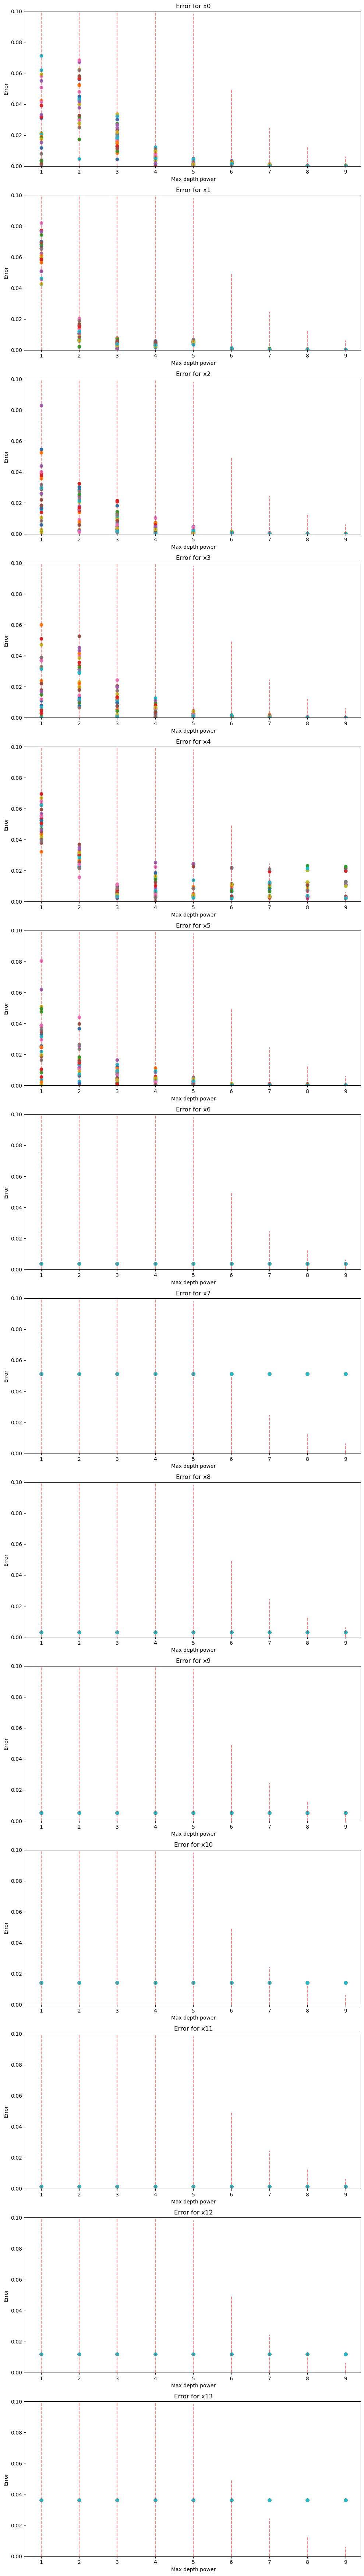

In [1080]:
plot_many_estimate_error_scaling(x, xhat_vecs, max_depth_powers)